# Valid Pairings

**Goal:** From the `Analysis-Intuition` notebook, we learned that the MDR cut 
1. Cuts out a lot of the high $m_{4j}$ background
2. Seems to significantly sculpt our background distribution.

It was curious that for the 2 valid pairings category, we were seeing the signal for both of these pairings peak at the HC mass *but this also suggests that maybe $D_{HH}$ is not going to be a good metric to get the SM signal right*?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import uproot

from scipy.stats import pearsonr

import os
import sys
sys.path.append("../code")
from preprocess import read_tsv, fileDir, yr_short, triggers
from plotting import varEvolution, massPlane, normHist2d
from eventDisplays import truthJetMatch, twoValidPairings

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
physicsSample = 'SMNR'
run_one = False
trigger ='2016_triggers'

In [3]:
fDir = "../data/{}_PFlow/".format(physicsSample)
if run_one:
    fName = "files/df_f_0.22_000001.h5" # for lower stats
else:
    fName = "files/df_f_0.22_00*.h5"

In [4]:
myFiles = fDir + fName
dfs = []

for i, myFile in enumerate(glob.glob(myFiles)):

    print('{}. {}'.format(i+1,myFile))
    
    df = pd.read_hdf(myFile,key='df')
    loadMask = df.fourGoodJets & (df.nbtags >= 4) & df[trigger]
    #dfs.append(df.query('trigger').query('fourGoodJets').query('nbtags >= 4'))
    dfs.append(df.loc[loadMask,df.columns])
    
miniNtuple = pd.concat(dfs)

1. ../data/SMNR_PFlow/files/df_f_0.22_000009.h5
2. ../data/SMNR_PFlow/files/df_f_0.22_000018.h5
3. ../data/SMNR_PFlow/files/df_f_0.22_000010.h5
4. ../data/SMNR_PFlow/files/df_f_0.22_000005.h5
5. ../data/SMNR_PFlow/files/df_f_0.22_000002.h5
6. ../data/SMNR_PFlow/files/df_f_0.22_000004.h5
7. ../data/SMNR_PFlow/files/df_f_0.22_000007.h5
8. ../data/SMNR_PFlow/files/df_f_0.22_000012.h5
9. ../data/SMNR_PFlow/files/df_f_0.22_000017.h5
10. ../data/SMNR_PFlow/files/df_f_0.22_000016.h5
11. ../data/SMNR_PFlow/files/df_f_0.22_000014.h5
12. ../data/SMNR_PFlow/files/df_f_0.22_000003.h5
13. ../data/SMNR_PFlow/files/df_f_0.22_000008.h5
14. ../data/SMNR_PFlow/files/df_f_0.22_000001.h5
15. ../data/SMNR_PFlow/files/df_f_0.22_000011.h5
16. ../data/SMNR_PFlow/files/df_f_0.22_000013.h5
17. ../data/SMNR_PFlow/files/df_f_0.22_000015.h5
18. ../data/SMNR_PFlow/files/df_f_0.22_000006.h5


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [5]:
for c in miniNtuple.columns:
    if 'pair' in c:
        print(c)

pair0_Dhh
pair0_HC1_dRjj
pair0_HC1_drMatch
pair0_HC1_eta
pair0_HC1_hidx
pair0_HC1_m
pair0_HC1_pT
pair0_HC1_phi
pair0_HC2_dRjj
pair0_HC2_drMatch
pair0_HC2_eta
pair0_HC2_hidx
pair0_HC2_m
pair0_HC2_pT
pair0_HC2_phi
pair0_mask
pair1_Dhh
pair1_HC1_dRjj
pair1_HC1_drMatch
pair1_HC1_eta
pair1_HC1_hidx
pair1_HC1_m
pair1_HC1_pT
pair1_HC1_phi
pair1_HC2_dRjj
pair1_HC2_drMatch
pair1_HC2_eta
pair1_HC2_hidx
pair1_HC2_m
pair1_HC2_pT
pair1_HC2_phi
pair1_mask
pair2_Dhh
pair2_HC1_dRjj
pair2_HC1_drMatch
pair2_HC1_eta
pair2_HC1_hidx
pair2_HC1_m
pair2_HC1_pT
pair2_HC1_phi
pair2_HC2_dRjj
pair2_HC2_drMatch
pair2_HC2_eta
pair2_HC2_hidx
pair2_HC2_m
pair2_HC2_pT
pair2_HC2_phi
pair2_mask


### Study 1: Look at subdivisions of the $\Delta R_{jj}$ vs $m_{4j}$ plot 

First, if I got the wrong 4-jets, I want to see what this plot looks like.

Secondly, when I have the right four jets, I want to subdivide this plot into
1. Correct pairings
2. Incorrect pairings

which I can do by $\Delta R$ matching HC pairs to truth higgses


In [6]:
# For overlaying these curves!
m4j_min, m4j_max = 1, 1250 # GeV
m4j = np.linspace(m4j_min, m4j_max) 

Rmin_lead = 360 / m4j - 0.5
Rmax_lead = 653 / m4j + 0.475

Rmin_subl = 235 / m4j
Rmax_subl = 875 / m4j + 0.35

In [7]:
if 'triggers' in trigger:
    subDir = '{}_{}'.format(physicsSample,yr_short[int(trigger[:4])])
else:
    for year in [2015,2016]:
        if trigger in triggers[year]:
            subDir = '{}_{}'.format(physicsSample,yr_short[year])


In [8]:
cmap_dr = "RdPu"
c_evt = 'C4'
c_lead = 'rebeccapurple'
c_subl = 'navy'

my_title = 'SM NR: Selecting 4 good jets'
triggerText = trigger.replace("_"," ") if 'triggers' in trigger else trigger
figDir = "../figures/{}/{}/".format(subDir,trigger)
baseFigName = "fourGoodJets"

**Get the mask for the "incorrect jets" plot**

So there are *two* ways we could get the wrong jets:
1. The $\Delta R$ between the closest truth quark selected anlayis jet is larger than 0.3
2. Multiple quarks are matched to the same jet (by looking at a few events, these are normally very high $p_T$ higgses, so good candidates for sensitivity from the boosted analysis)

In [11]:
badJets = miniNtuple.badJets.values

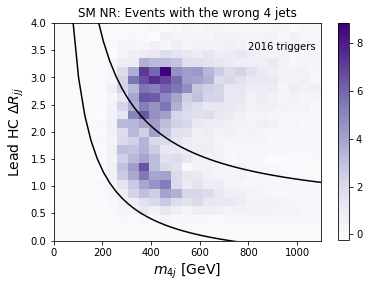

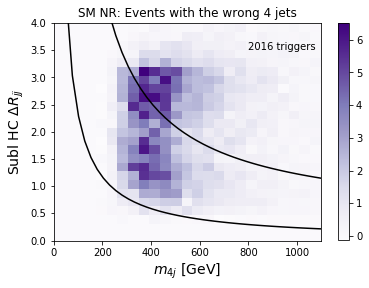

In [12]:
m4j_x3 = np.concatenate([miniNtuple.loc[badJets,'m4j']]*3,axis=0)

dRjj1s = np.concatenate([miniNtuple.loc[badJets,'pair{}_HC1_dRjj'.format(i)] for i in range(3)],axis=0)
dRjj2s = np.concatenate([miniNtuple.loc[badJets,'pair{}_HC2_dRjj'.format(i)] for i in range(3)],axis=0)

ws = np.concatenate([miniNtuple.loc[badJets,'mc_sf']]*3,axis=0)

for dRjj,HC_ID, dRmin, dRmax, c, i in zip([dRjj1s,dRjj2s],['Lead','Subl'],
                                          [Rmin_lead,Rmin_subl],[Rmax_lead,Rmax_subl],
                                          ['k','k'],[1,2]):

    plt.figure()
    plt.hist2d(m4j_x3, dRjj,
               bins=25,range=[(0,1100),(0,4)],
               cmap="Purples",weights=ws)
    plt.colorbar()

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(HC_ID+' HC $\Delta R_{jj}$',fontsize=14)

    plt.title("SM NR: Events with the wrong 4 jets")

    # Overlay the curves that we're cutting on for dRjj
    plt.plot(m4j,dRmin, c)
    plt.plot(m4j,dRmax, c)
    
    plt.text(1075,3.5,triggerText,horizontalalignment='right')
    
    plt.savefig('{}/{}_HC{}_dRjj_m4j_wrongJets.pdf'.format(figDir,baseFigName,i))
    
plt.show()

**Question:** How often does this MDR cut eliminate the crap jets?

In [13]:
np.sum(miniNtuple.loc[badJets & ~miniNtuple.MDR,'mc_sf']) / np.sum(miniNtuple.loc[badJets,'mc_sf'])

0.35235857833504586

**Comments from Michael from April $11^{th}$:**  It's important that we define correct match using information from the truth level information of which higgses decay to which higgses.  this is now calculated in my `preprocess.py` script in the `corrctPair` column.

In [24]:
N = np.sum(~badJets)

correct_mask = np.zeros((N,3)).astype(bool)
incorrect_mask = np.ones((N,3)).astype(bool)

for i,pidx in enumerate(miniNtuple.loc[~badJets,'correctPair']):
    correct_mask[i,pidx] = True
    incorrect_mask[i,pidx] = False

**Next:** Split these histograms into two for the correct and incorrect pairings


In [26]:
hc1_cols = ['pair{}_HC1_dRjj'.format(i) for i in range(3)]
hc2_cols = ['pair{}_HC2_dRjj'.format(i) for i in range(3)]

hc1_dRjj_correct = miniNtuple.loc[~badJets,hc1_cols].values[correct_mask]
hc2_dRjj_correct = miniNtuple.loc[~badJets,hc2_cols].values[correct_mask]

hc1_dRjj_incorrect = miniNtuple.loc[~badJets,hc1_cols].values[incorrect_mask]
hc2_dRjj_incorrect = miniNtuple.loc[~badJets,hc2_cols].values[incorrect_mask]

m4js_x2 = np.concatenate(miniNtuple.loc[~badJets,['m4j']*2].values)
ws_x2 = np.concatenate(miniNtuple.loc[~badJets,['mc_sf']*2].values)

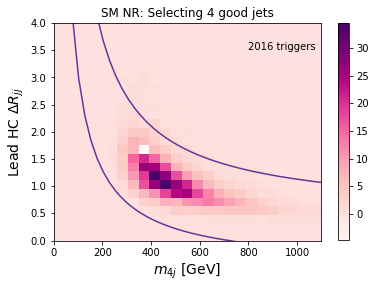

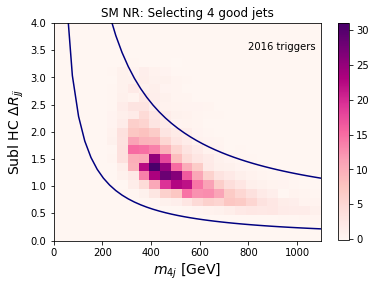

In [27]:
for dRjj,HC_ID, dRmin, dRmax, c, i in zip([hc1_dRjj_correct,hc2_dRjj_correct],['Lead','Subl'],
                                          [Rmin_lead,Rmin_subl],[Rmax_lead,Rmax_subl],
                                          [c_lead,c_subl],[1,2]):

    plt.figure()
    plt.hist2d(miniNtuple.loc[~badJets,'m4j'], dRjj,
               bins=25,range=[(0,1100),(0,4)],
               cmap=cmap_dr,weights=miniNtuple.loc[~badJets,'mc_sf'])
    plt.colorbar()

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(HC_ID+' HC $\Delta R_{jj}$',fontsize=14)

    plt.title(my_title)

    # Overlay the curves that we're cutting on for dRjj
    plt.plot(m4j,dRmin, c)
    plt.plot(m4j,dRmax, c)
    
    plt.text(1075,3.5,triggerText,horizontalalignment='right')
    
    plt.savefig('{}/fourGoodJets_HC{}_dRjj_m4j_correctPairings.pdf'.format(figDir,i))
    
plt.show()

This is *awesome*, and a great sanity check that the cut is doing exactly what we want it to do :)

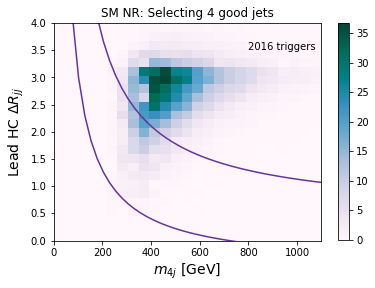

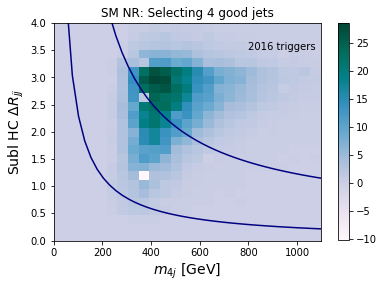

In [28]:
for dRjj,HC_ID, dRmin, dRmax, c, i in zip([hc1_dRjj_incorrect,hc2_dRjj_incorrect],['Lead','Subl'],
                                          [Rmin_lead,Rmin_subl],[Rmax_lead,Rmax_subl],
                                          [c_lead,c_subl],[1,2]):

    plt.figure()
    plt.hist2d(m4js_x2, dRjj,
               bins=25,range=[(0,1100),(0,4)],
               cmap="PuBuGn",weights=ws_x2)
    plt.colorbar()

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(HC_ID+' HC $\Delta R_{jj}$',fontsize=14)

    plt.title(my_title)

    # Overlay the curves that we're cutting on for dRjj
    plt.plot(m4j,dRmin, c)
    plt.plot(m4j,dRmax, c)
    
    plt.text(1075,3.5,triggerText,horizontalalignment='right')
    
    plt.savefig('{}/fourGoodJets_HC{}_dRjj_m4j_incorrectPairings.pdf'.format(figDir,i))
    
plt.show()

**Question:** How often does the current pairing algorithm get the correct pair, broken down by the # of valid pairings?

Should provide two versions of this number... for requiring the four jets be correct and not?

In [29]:
index = ['{} valid pairing'.format(pi) for pi in [1,2,3]]
col = 'Algorithm Correct'
algSuccess = pd.DataFrame(0,index=index,columns=[col])

for nPairs in [1,2,3]:
    
    pi_mask = (miniNtuple.nValidPairs == nPairs) 
    
    num = np.sum(miniNtuple.loc[(miniNtuple.chosenPair == miniNtuple.correctPair) & pi_mask,'mc_sf']) 
    den = np.sum(miniNtuple.loc[pi_mask,'mc_sf']) 
    
    algSuccess.loc['{} valid pairing'.format(nPairs),col] = num / den
    
    
print('Without requiring that we got the right 4 jets')
algSuccess.round(3)

Without requiring that we got the right 4 jets


Algorithm Correct
1 valid pairing              0.860
2 valid pairing              0.638
3 valid pairing              0.453

In [30]:
for nPairs in [1,2,3]:
    
    pi_mask = (miniNtuple.nValidPairs == nPairs) & (~badJets)
    
    num = np.sum(miniNtuple.loc[(miniNtuple.chosenPair == miniNtuple.correctPair) & pi_mask,'mc_sf']) 
    den = np.sum(miniNtuple.loc[pi_mask,'mc_sf']) 
    
    algSuccess.loc['{} valid pairing'.format(nPairs),col] = num / den
    
print('Requiring that we got the right 4 jets')
algSuccess.round(3)

Requiring that we got the right 4 jets


Algorithm Correct
1 valid pairing              0.991
2 valid pairing              0.764
3 valid pairing              0.640

**Note:** The pairing accuracy statement from the paper is:

"In signal simulation the pairing of jets (when four b-jets have been identified) is correct in at least 90% of the events, depending on $m_{4j}$."

My number (85.7%) after the MDR cuts is slightly lower, but in the ballpark? I think I should be cognizant of this discrepancy, and maybe careful about how I define these metrics.

**Michael's comments from April $11^{th}$:** It's important not only to calculate that the pairing is correct, *but that the correct pairing is valid*.


**New goal:** Calculate
- P(correct pairing is valid | 4 $b_H$)
- P(correct pairing | 4 $b_H$ && correct pair is valid)

and also broken down by the number of pairings.


**Implementation trick:** I'll need to use the `pair{i}_mask` columns, and I think I'll just add a new column to the df: `correctPairValid`.

In [31]:
miniNtuple['correctPairValid'] = False

pair_cols = ['pair{}_mask'.format(i) for i in range(3)]

for ievt, rows in miniNtuple.loc[~badJets,pair_cols + ['correctPair']].iterrows():
    
    key = 'pair{}_mask'.format(rows['correctPair'])
    miniNtuple.loc[ievt,'correctPairValid'] = rows[key]


In [32]:
index = ['{} valid pairing'.format(pi) for pi in [1,2,3]]
col = 'P[ Correct pairing is valid | (4 $b_H$) && (X valid pairings) ]'
algValid = pd.DataFrame(0,index=index,columns=[col])

In [33]:
'''
P(correct pair is valid | 4 bH)
'''

num = np.sum(miniNtuple.loc[miniNtuple.correctPairValid & (~badJets),'mc_sf'])
den = np.sum(miniNtuple.loc[(~badJets),'mc_sf']) 

print('P(correct pair is valid | 4 bH) = {:.4f}'.format(num / den))
print('P(correct pair is valid | 4 bH & MDR) = {:.4f}'.format(num / np.sum(miniNtuple.loc[(~badJets) & miniNtuple.MDR,'mc_sf'])))

for nPairs in [1,2,3]:
    
    pi_mask = (miniNtuple.nValidPairs == nPairs) & (~badJets)
    
    num = np.sum(miniNtuple.loc[miniNtuple.correctPairValid & pi_mask,'mc_sf']) 
    den = np.sum(miniNtuple.loc[pi_mask,'mc_sf']) 
    
    algValid.loc['{} valid pairing'.format(nPairs),col] = num / den
    
algValid.round(3)

P(correct pair is valid | 4 bH) = 0.9451
P(correct pair is valid | 4 bH & MDR) = 0.9909


P[ Correct pairing is valid | (4 $b_H$) && (X valid pairings) ]
1 valid pairing                                              0.991              
2 valid pairing                                              0.988              
3 valid pairing                                              1.000

**Question:** How do I check if this number is correct?

- I can look at the hist of the # of valid pairings, and if I normalize it, I can take the weighted sum of the values in this table to check against the aggregate number.


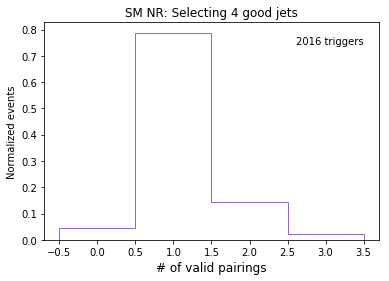

In [34]:
n,_,_ = plt.hist(miniNtuple.nValidPairs[~badJets],4,(-0.5,3.5),color=c_evt,histtype='step',
         weights=miniNtuple.mc_sf[~badJets],density=True)
plt.xlabel('# of valid pairings',fontsize=12)
plt.ylabel('Normalized events')
plt.title(my_title)

_,ymax = plt.ylim()
plt.text(3.5,0.9*ymax,triggerText,horizontalalignment='right')

plt.savefig('{}/fourGoodJets_validPairings.pdf'.format(figDir))
plt.show()

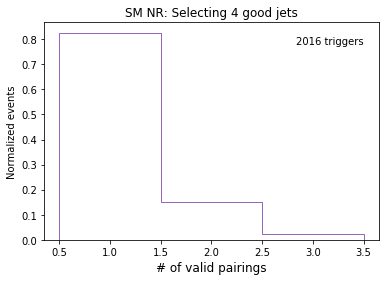

In [35]:
plt.hist(miniNtuple.nValidPairs[~badJets],3,(0.5,3.5),color=c_evt,histtype='step',
         weights=miniNtuple.mc_sf[~badJets],density=True)
plt.xlabel('# of valid pairings',fontsize=12)
plt.xlabel('# of valid pairings',fontsize=12)
plt.ylabel('Normalized events')
plt.title(my_title)

_,ymax = plt.ylim()
plt.text(3.5,0.9*ymax,triggerText,horizontalalignment='right')

plt.savefig('{}/MDR_validPairings_norm.pdf'.format(figDir))
plt.show()

In [36]:
np.sum(n[1:]*algValid['P[ Correct pairing is valid | (4 $b_H$) && (X valid pairings) ]'].values)

0.9450783879769724

Good news, *yes* this makes sense, and this table with the number of valid pairings gives me an intuition for how often we're passing each of the valid pariings criterion.

And I think this is a super interesting number to keep in mind, because it tells us how tightening our cuts will increase the probability that we lose the valid pair.

In [37]:
col = 'P[ Correct pair | (4 $b_H$) && (correct pair valid) && (X valid pairings) ]'
algSuccess = pd.DataFrame(0,index=index,columns=[col])

In [38]:
'''
P(correct pair is valid | 4 bH)
'''

num = np.sum(miniNtuple.loc[(miniNtuple.chosenPair == miniNtuple.correctPair) & miniNtuple.correctPairValid,'mc_sf'])
den = np.sum(miniNtuple.loc[miniNtuple.correctPairValid,'mc_sf']) 

print('P(correct pair | 4 bH && correct pair valid) = {:.4f}'.format(num / den))

for nPairs in [1,2,3]:
    
    pi_mask = (miniNtuple.nValidPairs == nPairs) & miniNtuple.correctPairValid
    
    num = np.sum(miniNtuple.loc[(miniNtuple.chosenPair == miniNtuple.correctPair) & pi_mask,'mc_sf']) 
    den = np.sum(miniNtuple.loc[pi_mask,'mc_sf']) 
    
    algSuccess.loc['{} valid pairing'.format(nPairs),col] = num / den
    
algSuccess.round(3)

P(correct pair | 4 bH && correct pair valid) = 0.9575


P[ Correct pair | (4 $b_H$) && (correct pair valid) && (X valid pairings) ]
1 valid pairing                                              1.000                          
2 valid pairing                                              0.773                          
3 valid pairing                                              0.640

In [39]:
# Sanity check
np.sum(n[1:]*algSuccess['P[ Correct pair | (4 $b_H$) && (correct pair valid) && (X valid pairings) ]'].values)/np.sum(n[1:])

0.9574980546201421

The 2 valid pairings category only accounts for $\approx$ 10% of the events, so fucking up on 10% of the jets in the 2 valid pairings category amounts to messing up on 1% of the events overall.

**Opening angles between jets**

So, we're sort of in the process of trying to disentangle *why* the 2 valid pairings category is peaking right in our signal region, so one of the items that Max wanted me to follow-up on was what the opening angles between the jets looked like for this two valid pairings category.


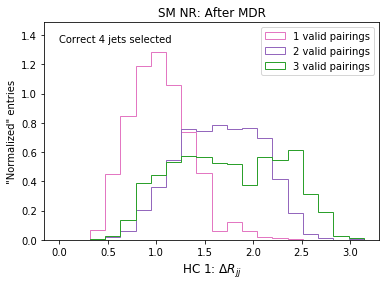

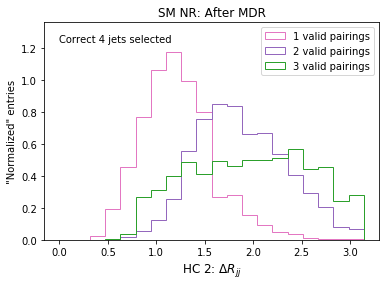

In [40]:
for HC_idx, hc_cols in zip([1,2],[hc1_cols,hc2_cols]): 

    plt.figure()
    
    for nPairs,c in zip([1,2,3],['C6','C4','C2']):

        # Get the masses
        mask_pi = (miniNtuple.nValidPairs == nPairs) & (~badJets)
        pair_mask = miniNtuple.loc[mask_pi,pair_cols].values

        dRjj = miniNtuple.loc[mask_pi,hc_cols].values

        w_pi = np.concatenate(miniNtuple.loc[mask_pi,['mc_sf']*nPairs].values)

        plt.hist(dRjj[pair_mask],20,(0,np.pi),weights=w_pi, density=True, color=c,
                 label='{} valid pairings'.format(nPairs),histtype='step')
      
    ymin,ymax = plt.ylim()
    plt.text(0,ymax,'Correct 4 jets selected')
    plt.ylim(ymin,1.1*ymax)
    
    plt.title('SM NR: After MDR')
    plt.xlabel('HC {}: '.format(HC_idx) + '$\Delta R_{jj}$',fontsize=12)
    plt.ylabel('"Normalized" entries')
    plt.legend()
    plt.savefig('{}/MDR_HC{}_dRjj_validPairs_goodJets.pdf'.format(figDir,HC_idx),bbox_inches='tight')

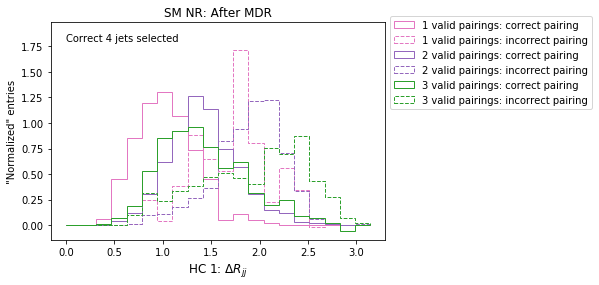

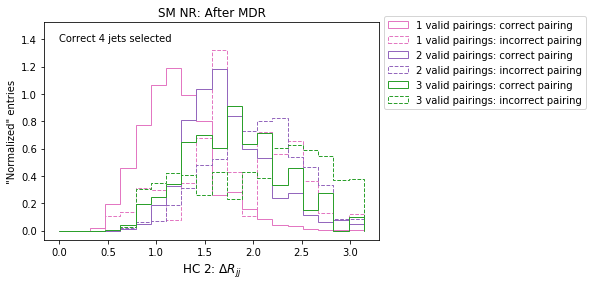

In [41]:
for HC_idx, hc_cols in zip([1,2],[hc1_cols,hc2_cols]): 

    plt.figure()
    
    for nPairs,c in zip([1,2,3],['C6','C4','C2']):

        # Get the masses
        mask_pi = (miniNtuple.nValidPairs == nPairs) & (~badJets)
        pair_mask = miniNtuple.loc[mask_pi,pair_cols].values

        dRjj = miniNtuple.loc[mask_pi,hc_cols].values
        w_x3 = np.concatenate([miniNtuple.loc[mask_pi,['mc_sf']]]*3,axis=1)
        
        nv_correct = pair_mask & correct_mask[(miniNtuple.nValidPairs == nPairs)[~badJets]]
        nv_incorect = pair_mask & incorrect_mask[(miniNtuple.nValidPairs == nPairs)[~badJets]]
        
        plt.hist(dRjj[nv_correct], 20,(0,np.pi), weights=w_x3[nv_correct], 
                 color=c, density=True, #log=True, #
                 label='{} valid pairings: correct pairing'.format(nPairs),histtype='step')
        
        plt.hist(dRjj[nv_incorect], 20,(0,np.pi), weights=w_x3[nv_incorect], 
                 color=c, density=True, #log=True, #
                 label='{} valid pairings: incorrect pairing'.format(nPairs),histtype='step',linestyle='--')
         
    ymin,ymax = plt.ylim()
    plt.text(0,ymax,'Correct 4 jets selected')
    plt.ylim(ymin,1.1*ymax)
    
    plt.title('SM NR: After MDR')
    plt.xlabel('HC {}: '.format(HC_idx) + '$\Delta R_{jj}$',fontsize=12)
    plt.ylabel('"Normalized" entries')
    plt.legend(bbox_to_anchor=(1,1.05))
    plt.savefig('{}/MDR_HC{}_dRjj_validPairs_goodJets_correctIncorrectPairs.pdf'.format(figDir,HC_idx),bbox_inches='tight')

For my talk, Michael wanted me to break each plot into three for the each valid pairing category.

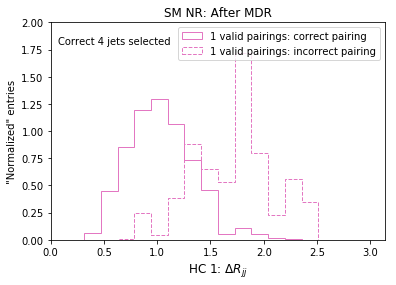

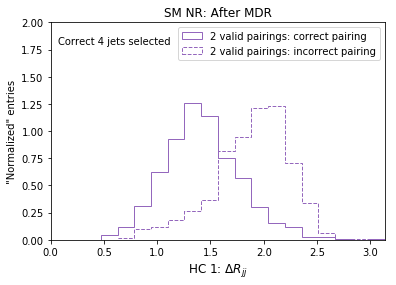

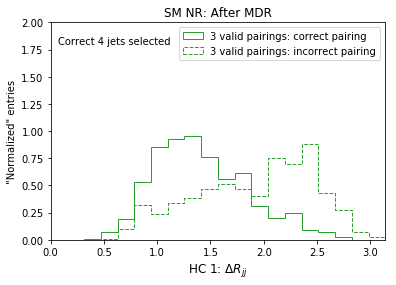

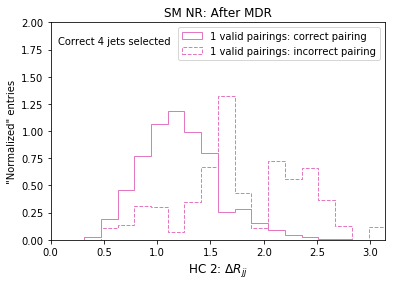

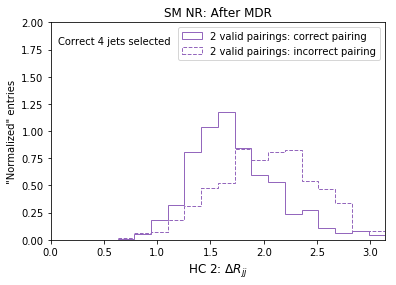

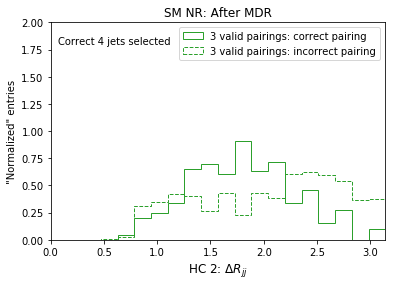

In [42]:
for HC_idx, hc_cols in zip([1,2],[hc1_cols,hc2_cols]): 

    for nPairs,c in zip([1,2,3],['C6','C4','C2']):

        plt.figure()
        
        # Get the masses
        mask_pi = (miniNtuple.nValidPairs == nPairs) & (~badJets)
        pair_mask = miniNtuple.loc[mask_pi,pair_cols].values

        dRjj = miniNtuple.loc[mask_pi,hc_cols].values
        w_x3 = np.concatenate([miniNtuple.loc[mask_pi,['mc_sf']]]*3,axis=1)
        
        nv_correct = pair_mask & correct_mask[(miniNtuple.nValidPairs == nPairs)[~badJets]]
        nv_incorect = pair_mask & incorrect_mask[(miniNtuple.nValidPairs == nPairs)[~badJets]]
        
        plt.hist(dRjj[nv_correct], 20,(0,np.pi), weights=w_x3[nv_correct], 
                 color=c, density=True, #log=True, #
                 label='{} valid pairings: correct pairing'.format(nPairs),histtype='step')
        
        plt.hist(dRjj[nv_incorect], 20,(0,np.pi), weights=w_x3[nv_incorect], 
                 color=c, density=True, #log=True, #
                 label='{} valid pairings: incorrect pairing'.format(nPairs),histtype='step',linestyle='--')
         
        plt.text(0.07,1.8,'Correct 4 jets selected',fontsize=10)
        plt.ylim(0,2)
        plt.xlim(0,np.pi)
        
        plt.title('SM NR: After MDR')
        plt.xlabel('HC {}: '.format(HC_idx) + '$\Delta R_{jj}$',fontsize=12)
        plt.ylabel('"Normalized" entries')
        plt.legend()
        plt.savefig('{}/MDR_HC{}_dRjj_{}validPairs_goodJets_correctIncorrectPairs.pdf'.format(figDir,HC_idx,nPairs),bbox_inches='tight')
        plt.show()

**Conclusion:**

We could redo the analysis selecting the *minimum* $\Delta R_{jj}$, and see if this does a better job with not sculpting our background!

Caterina thought it might do just as bad, because if we select the min $\Delta R_{jj}$, we'll be preferentially selecting background events with closer jets, but still... something we could look at! 

**Thoughts:**

Ok, so I think it's important to clarify what we *mean* by isotropic. According to study 3, the HCs are more back-to-back for the one valid pairing category, but it seems like the opening angles between the constituents are also closer to each other.


I think this makes sense since $\Delta R \leq \frac{2m}{p_T}$. The more *massive* $m_{4j}$ gives more kick to the HCs, and subsequently the allowed opening angle for the constituents is smaller.

To probe this hypothesis, I'm going to make a 2d histogram, broken down by the number of valid pairings and then I can overlay the equation for $\Delta R = \frac{2m}{p_T}$ to see if my logic makes sense.

I think this is really just a way to see if Patrick got as much information from the opening angles as is possible. 

In [43]:
pt1_cols = ['pair{}_HC1_pT'.format(i) for i in range(3)]
pt2_cols = ['pair{}_HC1_pT'.format(i) for i in range(3)]

In [44]:
pt = np.linspace(0.1,750)
mH = 125

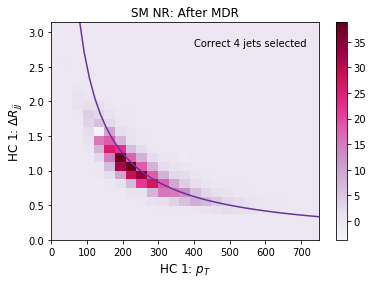

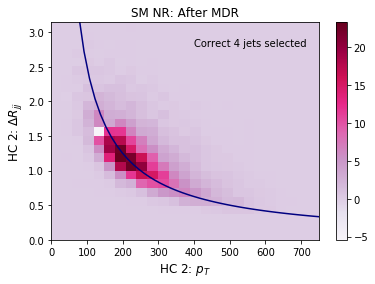

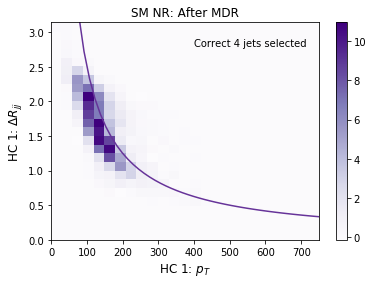

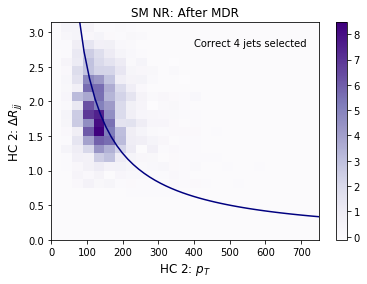

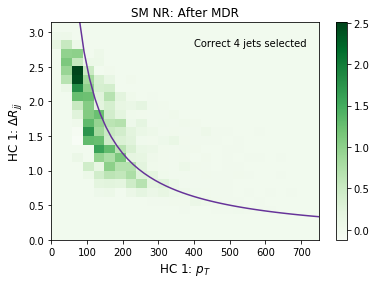

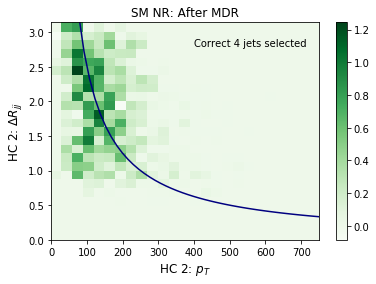

In [45]:
tag = '_goodJets'
text = 'Correct 4 jets selected'

for nPairs, cmap in zip([1,2,3],['PuRd','Purples','Greens']):

    mask_pi = (miniNtuple.nValidPairs == nPairs) & (~badJets)

    for HC_idx, hc_cols, pt_cols, c in zip([1,2],[hc1_cols,hc2_cols],[pt1_cols,pt2_cols],[c_lead,c_subl]): 

        plt.figure()

        pair_mask = miniNtuple.loc[mask_pi,pair_cols].values

        dRjj = miniNtuple.loc[mask_pi,hc_cols].values
        pts = miniNtuple.loc[mask_pi,pt_cols].values

        w_pi = np.concatenate(miniNtuple.loc[mask_pi,['mc_sf']*nPairs].values)

        plt.hist2d(pts[pair_mask],dRjj[pair_mask],
                   25,[(0,750),(0,np.pi)], weights=w_pi, cmap=cmap)
        plt.plot(pt, 2*mH /pt, c)

        plt.text(400,2.8,text)

        plt.title('SM NR: After MDR')
        plt.colorbar()
        plt.xlabel('HC {}: '.format(HC_idx) + '$p_T$',fontsize=12)
        plt.ylabel('HC {}: '.format(HC_idx) + '$\Delta R_{jj}$',fontsize=12)

        plt.savefig('{}/MDR_HC{}_dRjj_vs_pt_{}validPairs{}.pdf'.format(figDir,HC_idx,nPairs,tag),bbox_inches='tight')

Ok, it looks like the subleading HC more often has a distribution of unphysical $\Delta R_{jj}$s for a $p_T$ dependence $\Delta R_{jj}$ cut.

Perhaps I could break this plot down into the correct and incorrect pairings? 

It *might* also be interesting to see how the background looks!

### Study 2: Look at the $p_T$ of the *truth* higgses for each of the pairing categories

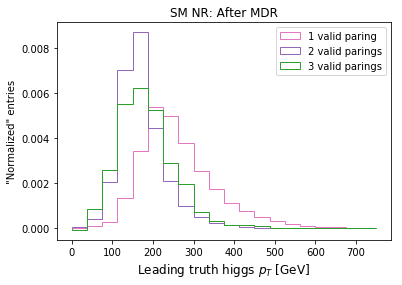

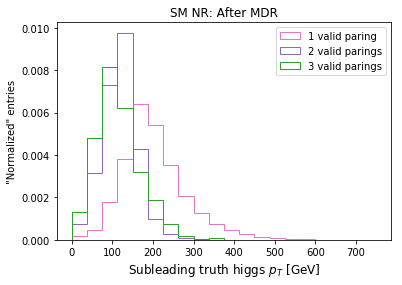

In [46]:
for ihc, hc_tag in enumerate(['Leading','Subleading']):
    
    plt.figure()
    
    for nPairs, c in zip([1,2,3],['C6','C4','C2']):

        mask = (miniNtuple.nValidPairs == nPairs)
        label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')
        
        plt.hist(miniNtuple.loc[mask,'h{}_pt'.format(ihc)],
                 bins=20, range=(0,750), label=label,
                 color=c, histtype='step', density=True,
                 weights=miniNtuple.loc[mask,'mcEventWeight'])

    plt.xlabel('{} truth higgs $p_T$ [GeV]'.format(hc_tag),fontsize=12)
    plt.ylabel('"Normalized" entries')
    plt.legend()
    plt.title('SM NR: After MDR')  
    plt.savefig('{}/h{}_pt_validPairings.pdf'.format(figDir,ihc))
    
plt.show()

**Conclusion:**

The one valid pairing distribution has much more of a kick than the two valid pairings distribution, contributing to our intution that the two valid pairings are for events that are more isotropic.

## Study 3: Look at the opening angle between the higgses, broken down by the number of pairings

I'm going to want to do this at the truth level, to be consistent with the plots above.... but I could also look at $\Delta \eta$ between the HCs, since this is something that I have access to here, but it's sort of confounding b/c looking @ reco info at this stage assumes we've chosen a HC.

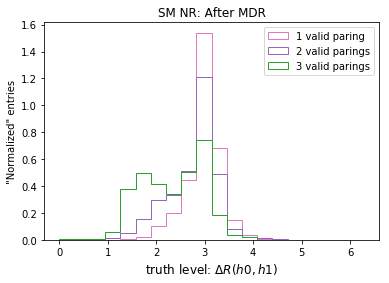

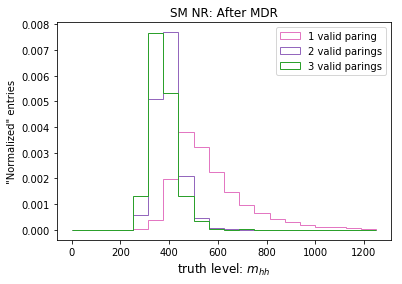

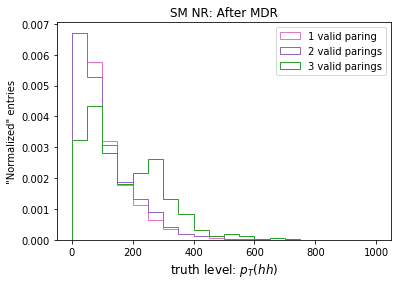

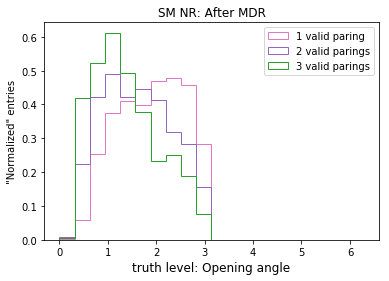

In [47]:
for var,xlabel,myRange in zip(['dr','m','pt','angle'],
                              ['$\Delta R(h0,h1)$','$m_{hh}$','$p_T(hh)$','Opening angle'],
                              [(0,2*np.pi),(0,1250),(0,1000),(0,2*np.pi)]):
    
    for nPairs, c in zip([1,2,3],['C6','C4','C2']):

        mask = (miniNtuple.nValidPairs == nPairs)
        label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')

        plt.hist(miniNtuple.loc[mask,'hh_'+var],
                 bins=20, range=myRange, label=label,
                 color=c, histtype='step', density=True,
                 weights=miniNtuple.loc[mask,'mcEventWeight'])

    plt.xlabel('truth level: '+xlabel,fontsize=12)
    plt.ylabel('"Normalized" entries')
    plt.legend()
    plt.title('SM NR: After MDR') 
    plt.savefig('{}/MDR_hh_{}_nValidPairings.pdf'.format(figDir,var))
    plt.show()

**Super cool!** This is showing that the events with one valid pairings are *more back-to-back*.

Rafael wanted me to overlay the reco distributions as well just after the pairing algorithm.

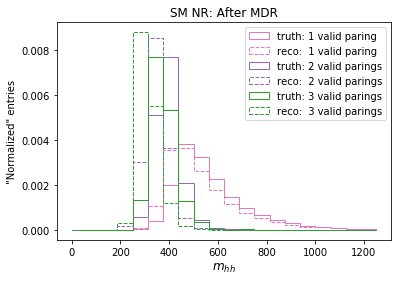

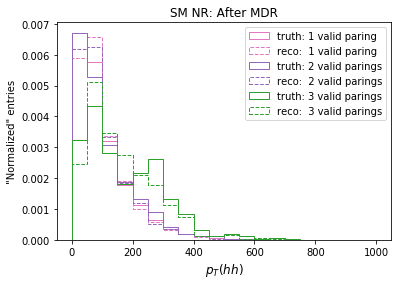

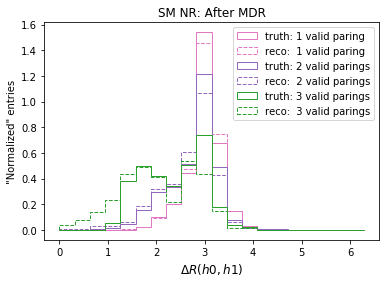

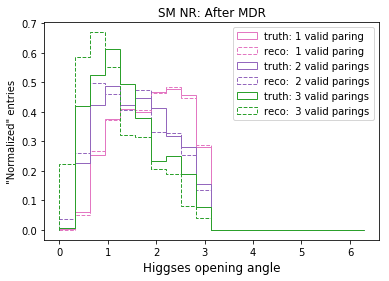

In [48]:
for var,xlabel,myRange in zip(['m','pt','dr','angle'],
                              ['$m_{hh}$','$p_T(hh)$','$\Delta R(h0,h1)$','Higgses opening angle'],
                              [(0,1250),(0,1000),(0,2*np.pi),(0,2*np.pi)]):
    
    fig = plt.figure(figsize=(6,5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4:,0])
    
    for nPairs, c in zip([1,2,3],['C6','C4','C2']):

        mask = (miniNtuple.nValidPairs == nPairs)
        label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')

        n_truth,edg,_ = ax1.hist(miniNtuple.loc[mask,'hh_'+var],
                         bins=20, range=myRange, label='truth: '+label,
                         color=c, histtype='step', density=True,
                         weights=miniNtuple.loc[mask,'mcEventWeight'])
        
        rkey = 'm4j' if var == 'm' else 'HCs_'+var
        n_reco,edg,_ = ax1.hist(miniNtuple.loc[mask,rkey],
                         bins=20, range=myRange, 
                         label='reco:  '+label,linestyle='--',
                         color=c, histtype='step', density=True,
                         weights=miniNtuple.loc[mask,'mcEventWeight'])

        ax2.plot(0.5 * (edg[:-1]+edg[1:]), 1- n_reco / n_truth, 
                 color=c, marker='.', linewidth=0)
        
    ax1.set_ylabel("\"Normalized\" Entries",fontsize=12)
    ax1.set_title('SM NR')
    ax1.legend()
    ax1.set_title('SM NR: After MDR') 
    
    ax2.set_xlabel(xlabel,fontsize=12)
    ax2.set_ylabel('fail / pass')
    ax2.plot([edg[0],edg[-1]],[0]*2,'k--')

    plt.savefig('{}/MDR_hh_{}_nValidPairings_reco_ratio.pdf'.format(figDir,var))
    plt.show()
    
    

In [ ]:
for var,xlabel,myRange in zip(['pt','eta','phi','E'],
                              ['$p_T$ [GeV]','$\eta$','$\phi$','$E$ [GeV]'],
                              [(0,500),(-2.5,2.5),(-np.pi,np.pi),(0,1000)]):
    
    for ih, htag, c in zip(range(2),['Leading','Subleading'],['rebeccapurple','navy']):
    
        key = 'h{}_{}'.format(ih,var)
    
    
        
    
        n_fail,edg,_ = ax1.hist(miniNtuple.loc[mask,key], bins=20, range=myRange, 
                                label='failed {} trigger'.format(trigger[:4]),
                                histtype='step', color=c, density=True, 
                                weights=miniNtuple.loc[mask,'mc_sf'])

        n_pass,edg,_ = ax1.hist(miniNtuple.loc[~mask,key], bins=20, range=myRange, 
                                label='passed {} trigger'.format(trigger[:4]),
                                histtype='step', color='k', density=True, 
                                weights=miniNtuple.loc[~mask,'mc_sf'])

        ax2.plot(0.5 * (edg[:-1]+edg[1:]), n_fail / n_pass, 
                 color=c, marker='.', linewidth=0)
        
        
        ax1.set_ylabel("\"Normalized\" Entries",fontsize=12)
        ax1.set_title('SM NR')
        ax1.legend()
        
        ax2.set_xlabel(htag+' truth higgs '+xlabel,fontsize=12)
        ax2.set_ylabel('fail / pass')
        
        ax2.plot([edg[0],edg[-1]],[1]*2,'k--')
        
        
        plt.savefig('{}/{}_ratio.pdf'.format(figDir,key))



Note: Michael said I should plot "reco / truth - 1" for these plots, or maybe just make them ratio plots?

I don't think tis plot was incredibly interesting for the types of pairings topology that we're trying to probe, but I *do* think that it's cool that $\Delta \eta_{hh}$ is probing new information about the event other than the pairing.

*I really want to do the anlaysis in $|\eta_{hh}|$ bins!*

### Study 4: Look at the other kinematic info broken down by # of valid pairings

I.e, I could first try out some truth level info, but it could get pretty busy pretty fast... I might ignore the 0 valid pairings category for this plot.

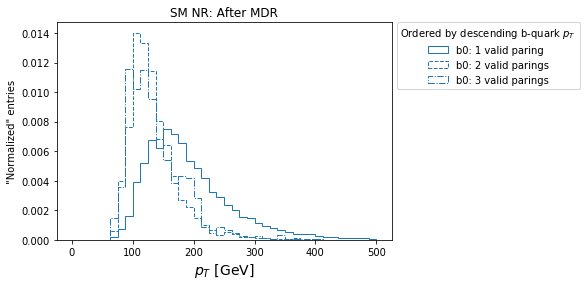

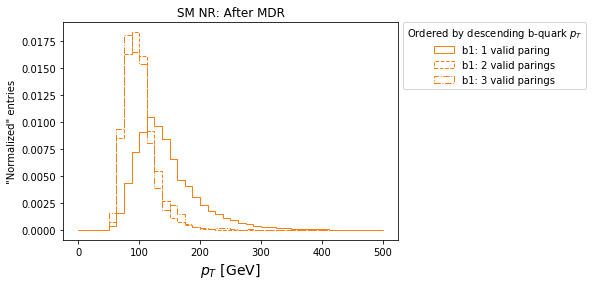

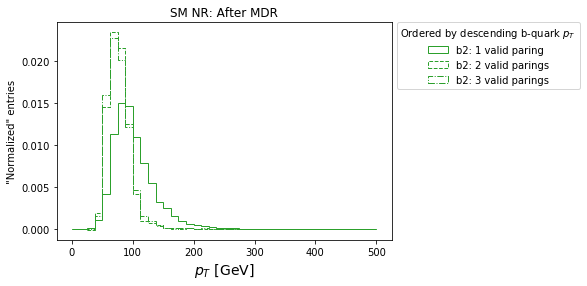

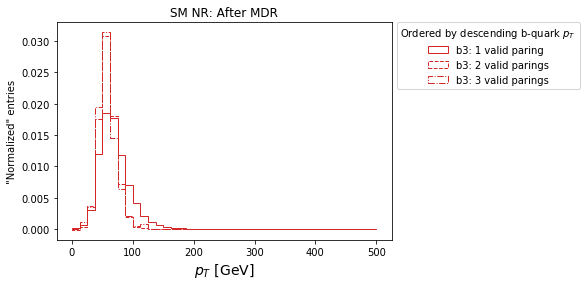

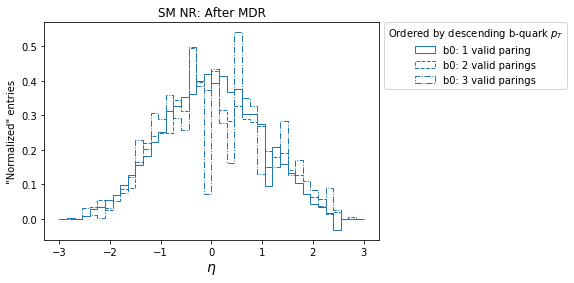

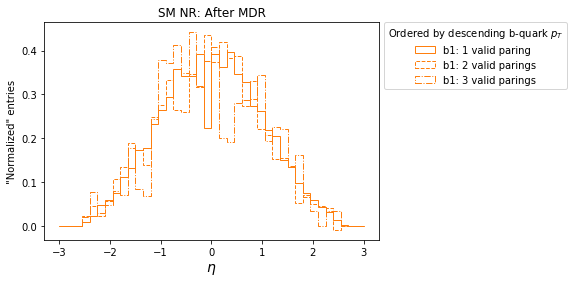

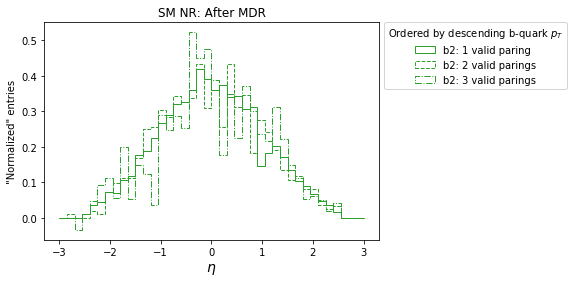

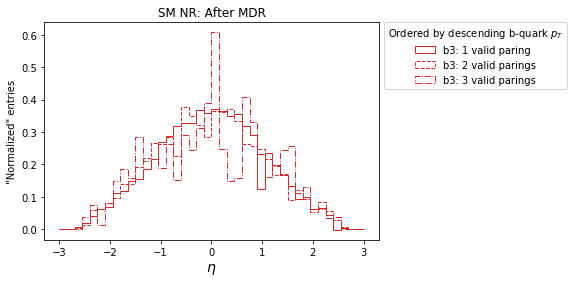

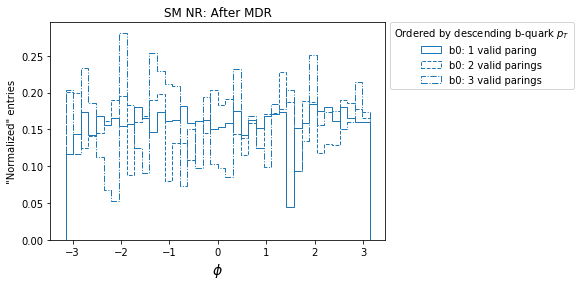

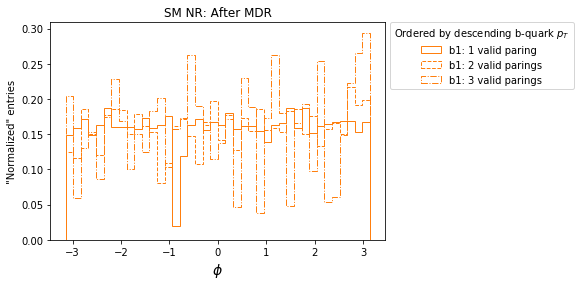

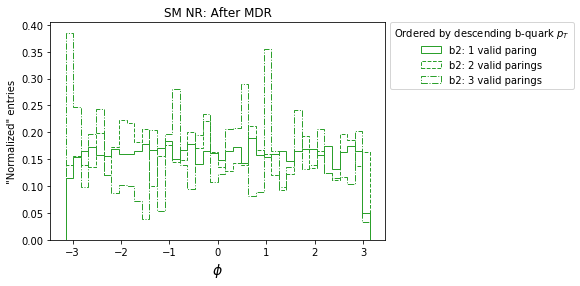

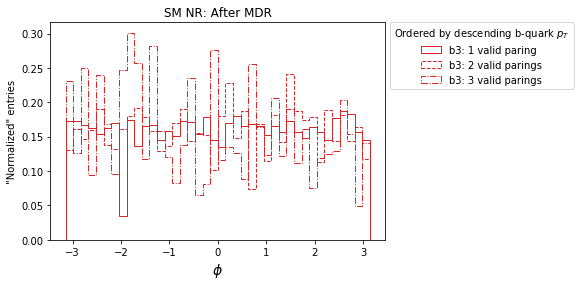

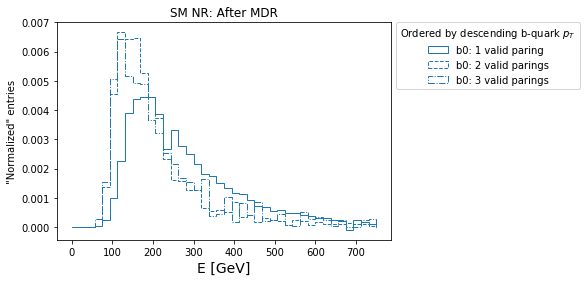

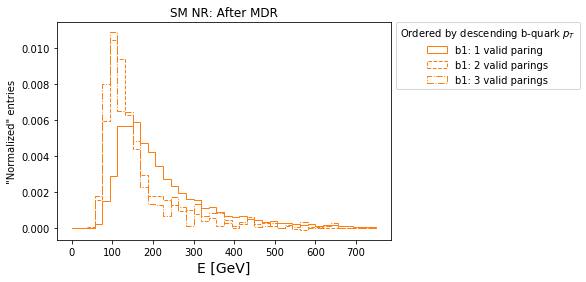

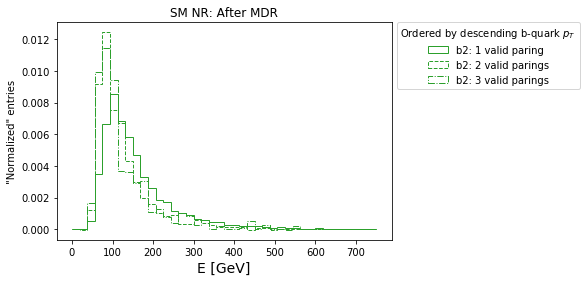

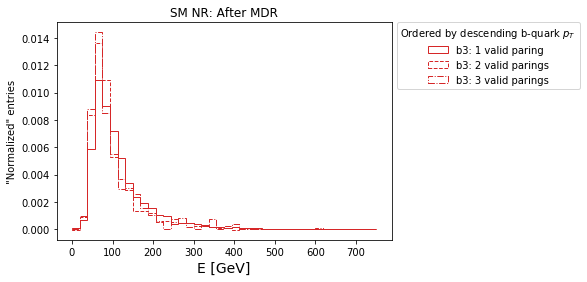

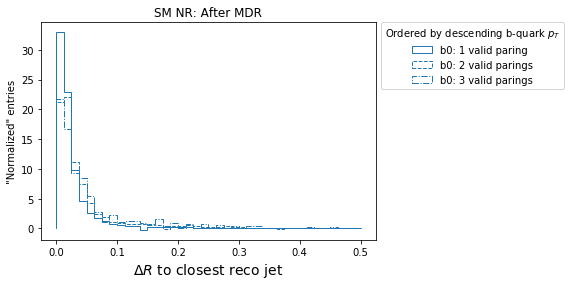

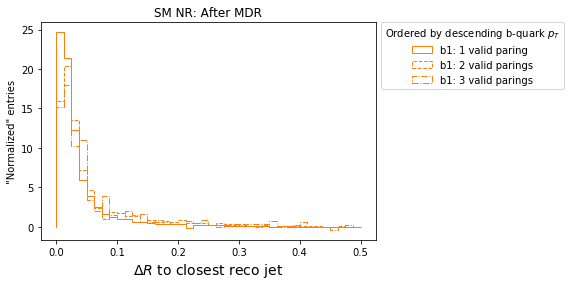

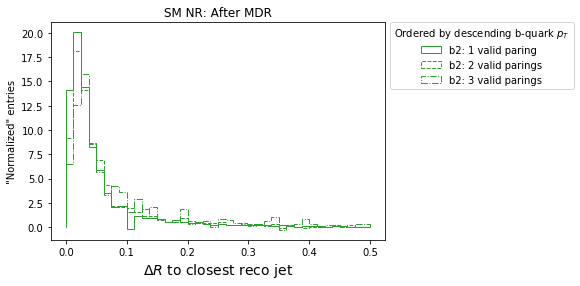

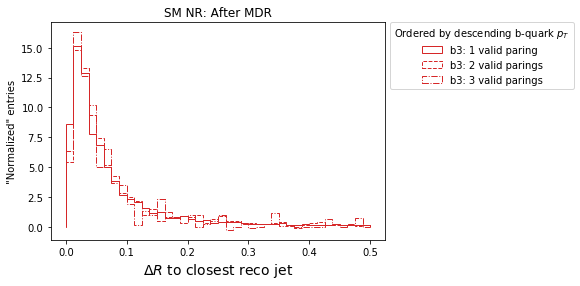

In [50]:
baseFigName = 'fourGoodJets'
my_title = 'SM NR: Selecting 4 good b-jets'

for var, nBins, myRange, xlabel in zip(['pt','eta','phi','E','drMatch'], [40]*5,
                                      [(0,500),(-3,3),(-np.pi,np.pi),(0,750),(0,0.5)],
                                      ['$p_T$ [GeV]','$\eta$','$\phi$','E [GeV]','$\Delta R$ to closest reco jet']):
    
    for ib in range(4):
    
        plt.figure()
        
        for nPairs, linestyle in zip([1,2,3],['-','--','-.']):

            mask = (miniNtuple.nValidPairs == nPairs)
        
            key = 'b{}_{}'.format(ib,var)
            label = 'b{}: {} valid paring{}'.format(ib,nPairs,'' if nPairs == 1 else 's')
            plt.hist(miniNtuple.loc[mask,key], bins=nBins, range=myRange,
                     color="C{}".format(ib),linestyle=linestyle,
                     histtype='step', label=label, density=True,
                     weights=miniNtuple.loc[mask,'mcEventWeight'])
                
        plt.legend(title='Ordered by descending b-quark $p_T$',bbox_to_anchor=(1,1.025))
        plt.xlabel(xlabel,fontsize=14)
        plt.ylabel('"Normalized" entries')
        plt.title('SM NR: After MDR')
    
        plt.savefig('{}/MDR_b{}_{}_nValidPairings'.format(figDir,ib,var))
        
plt.show()

For the opening angles between jets, I think I'll do this study with reco level information, since this is what I have available. 

**Probing "extra junk"**

Ok, so part of the story that we're building up here is that the more valid pairings are events with "more" kick, perhaps I could probe this by plotting $H_T^{rest}$?

In [51]:
for ievt, pts, etas, mv2s, btags in miniNtuple[['resolvedJets_pt','resolvedJets_eta','resolvedJets_MV2c10','resolvedJets_is_MV2c10_FixedCutBEff_70']].itertuples():
    miniNtuple.loc[ievt,'HT'] = np.sum(pts)
    
    chosenJets = (pts > 40) & (np.abs(etas) < 2.5) & btags
    
    idx  = np.argsort(mv2s[chosenJets])[::-1]
    chosenJets[idx][4:] = False
    
    miniNtuple.loc[ievt,'HTrest'] = np.sum(pts[~chosenJets])
    

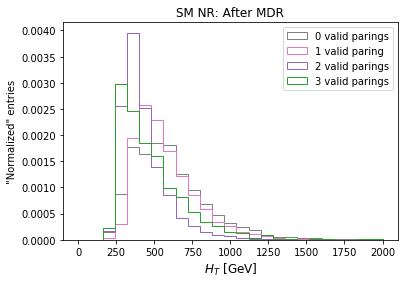

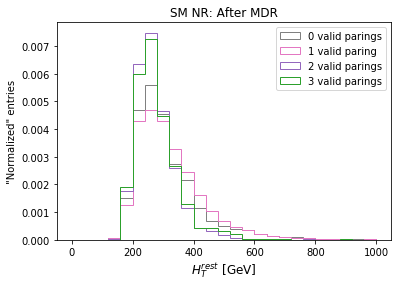

In [52]:
for var,myRange,xlabel in zip(['HT','HTrest'],[(0,2000),(0,1000)],['$H_T$ [GeV]','$H_T^{rest}$ [GeV]']):
    
    plt.figure()
    
    for nPairs, c in enumerate(['grey','C6','C4','C2']):

        mask = (miniNtuple.nValidPairs == nPairs)
        label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')
        
        plt.hist(miniNtuple.loc[mask,var],
                 bins=25, range=myRange, label=label,
                 color=c, histtype='step', density=True,
                 weights=miniNtuple.loc[mask,'mcEventWeight'])

    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel('"Normalized" entries')
    plt.legend()
    plt.title('SM NR: After MDR')  
    plt.savefig('{}/MDR_{}_validPairings.pdf'.format(figDir,var))
    
plt.show()

So maybe the metric we want is the asymmetry between $H_{T}^{rest}$ and $p_T(4-jets)$? This wasn't as infomative as I was hoping.

I could also plot the $p_T$ of the leading non b-tagged jet? Or the $p_T$ of the leading not-selected jet?


In [53]:
miniNtuple['lead_nonSel_pt'] = 0 

for ievt, indices in miniNtuple.loc[miniNtuple.MDR,['b{}_jidx'.format(i) for i in range(4)]].iterrows():
    
    if miniNtuple.loc[ievt,'nresolvedJets'] == 4:
        continue
    
    miniNtuple.loc[ievt,'lead_nonSel_pt'] = [pt for i, pt in enumerate(miniNtuple.loc[ievt,'resolvedJets_pt']) \
                                             if i not in list(indices)][0]   

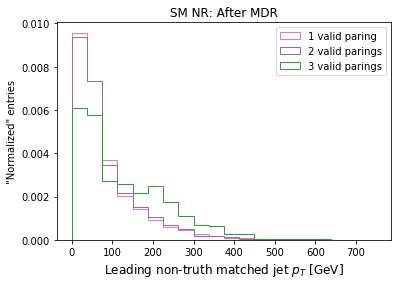

In [54]:
for nPairs,c in zip([1,2,3],['C6','C4','C2']):

    mask = (miniNtuple.nValidPairs == nPairs)
    label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')

    plt.hist(miniNtuple.loc[mask,'lead_nonSel_pt'],
             bins=20, range=(0,750), label=label,
             color=c, histtype='step', density=True,
             weights=miniNtuple.loc[mask,'mcEventWeight'])

plt.xlabel('Leading non-truth matched jet $p_T$ [GeV]'.format(hc_tag),fontsize=12)
plt.ylabel('"Normalized" entries')
plt.legend()
plt.title('SM NR: After MDR')  
plt.savefig('{}/MDR_lead_nonTruthMatchedJet_pt.pdf'.format(figDir,ihc))

plt.show()

Follow-up from Max: We should look at the ratio of this w/r.t. the $p_T$ of the Higgs system, if it's close to 1, then this is the one that is providing the recoil :)

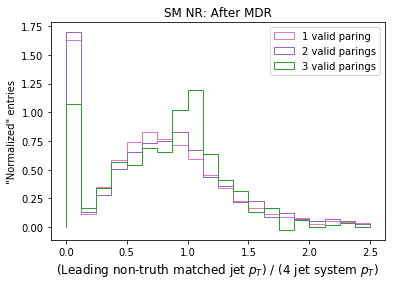

In [55]:
for nPairs,c in zip([1,2,3],['C6','C4','C2']):

    mask = (miniNtuple.nValidPairs == nPairs)
    label = '{} valid paring{}'.format(nPairs,'' if nPairs == 1 else 's')

    plt.hist(miniNtuple.loc[mask,'lead_nonSel_pt'] / miniNtuple.loc[mask,'HCs_pt'],
             bins=20, range=(0,2.5), label=label,
             color=c, histtype='step', density=True,
             weights=miniNtuple.loc[mask,'mcEventWeight'])

plt.xlabel('(Leading non-truth matched jet $p_T$) / (4 jet system $p_T$)'.format(hc_tag),fontsize=12)
plt.ylabel('"Normalized" entries')
plt.legend()
plt.title('SM NR: After MDR')  
plt.savefig('{}/MDR_lead_nonSelJet_pt_over_4jpt.pdf'.format(figDir))

plt.show()

Look at the correlation between nresolvedjets and the # of valid pairings.

In [56]:
for c in miniNtuple.columns:
    if 'resolved' in c:
        print(c)

nresolvedJets
resolvedJets_E
resolvedJets_HadronConeExclTruthLabelID
resolvedJets_MV2c10
resolvedJets_SF_MV2c10_FixedCutBEff_70
resolvedJets_eta
resolvedJets_is_MV2c10_FixedCutBEff_70
resolvedJets_phi
resolvedJets_pt


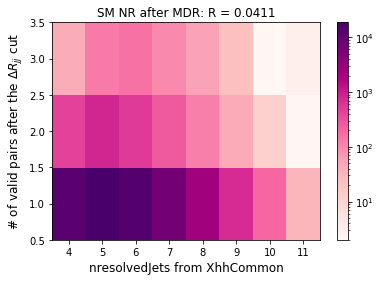

In [57]:
R,p = pearsonr(miniNtuple.loc[miniNtuple.MDR,'nresolvedJets'],miniNtuple.loc[miniNtuple.MDR,'nValidPairs'])

n, xedg, yedg, _ = plt.hist2d(miniNtuple.loc[miniNtuple.MDR,'nresolvedJets'],
                              miniNtuple.loc[miniNtuple.MDR,'nValidPairs'],
                              bins=(8,3),range=((3.5,11.5),(0.5,3.5)),
                              cmap=cmap_dr,norm=LogNorm())
plt.colorbar()
xlabel = 'nresolvedJets from XhhCommon'
ylabel = '# of valid pairs after the $\Delta R_{jj}$ cut'
plt.xlabel(xlabel,fontsize=12)
plt.ylabel(ylabel,fontsize=12)
plt.title('SM NR after MDR: R = {:.3}'.format(R))

plt.savefig('{}/MDR_nValidPairs_nresolvedJets.pdf'.format(figDir),
            bbox_inches='tight')
plt.show()

It still doesn't seem like a strong correlation to me... I should probably follow up from the appendix of the int note!

I could also normalize by row and plot the # of resolved jets for each # of valid pairings.


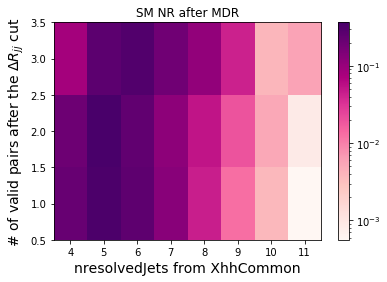

In [58]:
my_title='SM NR after MDR'

c = normHist2d(n,xedg,yedg,normCol=False,xlabel=xlabel,ylabel=ylabel,title=my_title,
               cmap=cmap_dr,returnCounts=True,figDir=figDir,
               figName='MDR_nValidPairs_nresolvedJets')

In [59]:
c.shape

(8, 3)

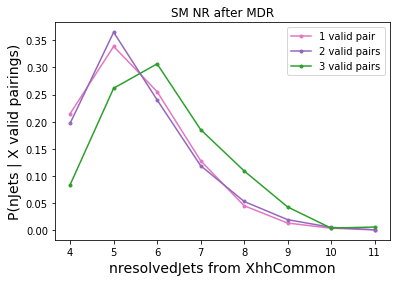

In [60]:
nJets = 0.5 * (xedg[:-1] + xedg[1:])

for i, nPairs, ci in zip(range(3), [1,2,3], ['C6','C4','C2']):
    label = '{} valid pair{}'.format(nPairs,'' if nPairs ==1 else 's')
    plt.plot(nJets,c[:,i], marker='.', label=label,color=ci)
    
plt.xlabel(xlabel,fontsize=14)
plt.ylabel(r'P(nJets | X valid pairings)',fontsize=14)
plt.title(my_title)
plt.legend()

plt.savefig('{}/MDR_nresolvedJets_given_nPairs.pdf'.format(figDir),
            bbox_inches='tight')
plt.show()

### Study 5: Event displays for events with two valid pairs

Ok, so last but not least, I'm going to make a few event displays.

I don't think this will help me a lot compared to what I've already done with learning the distributions, but they're fun to look at!!


In [61]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 6

In [62]:
miniNtuple.loc[697432]

2015_triggers                                                                               True
2016_triggers                                                                               True
HC1_eta                                                                                 0.602818
HC1_m                                                                                    120.848
HC1_ntag                                                                                       0
HC1_ntags                                                                                      2
HC1_pT                                                                                    267.34
HC1_phi                                                                                 0.292622
HC1_vecSum_pT                                                                             267.34
HC2_eta                                                                                  0.71737
HC2_m                         

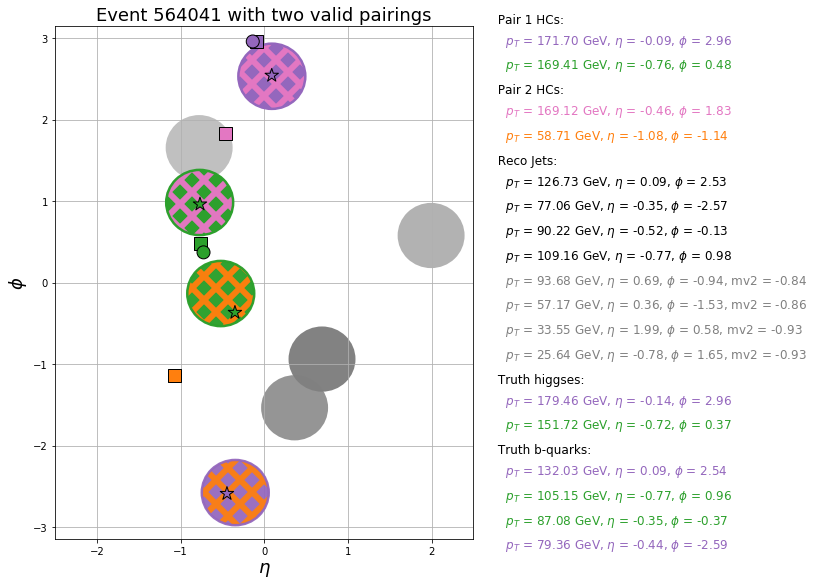

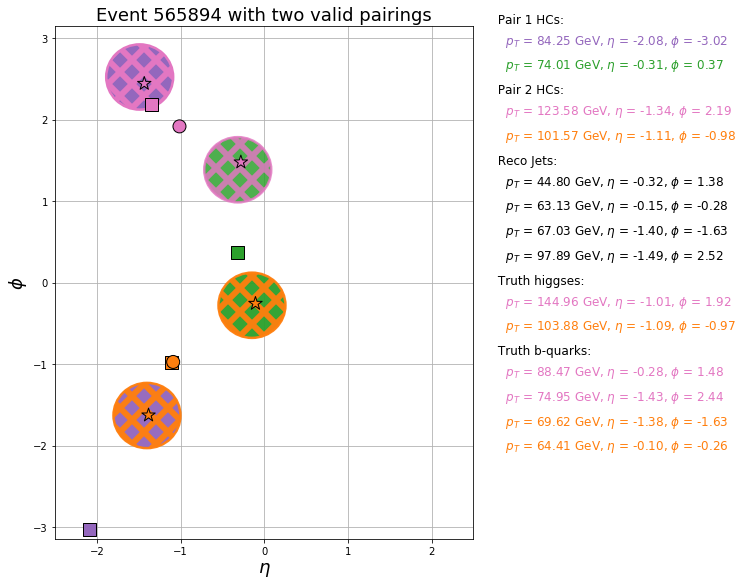

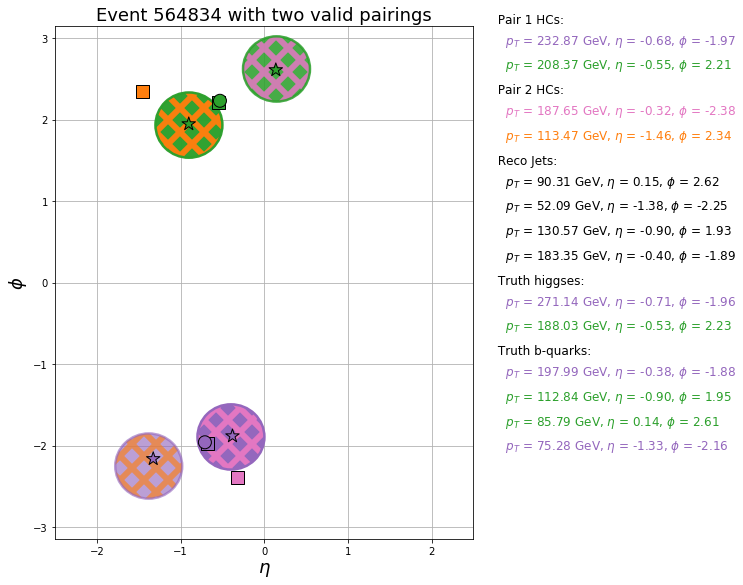

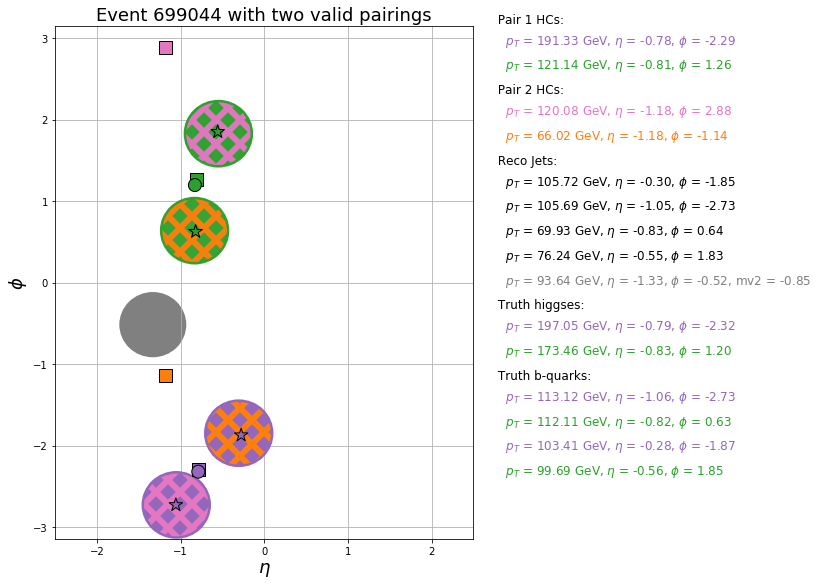

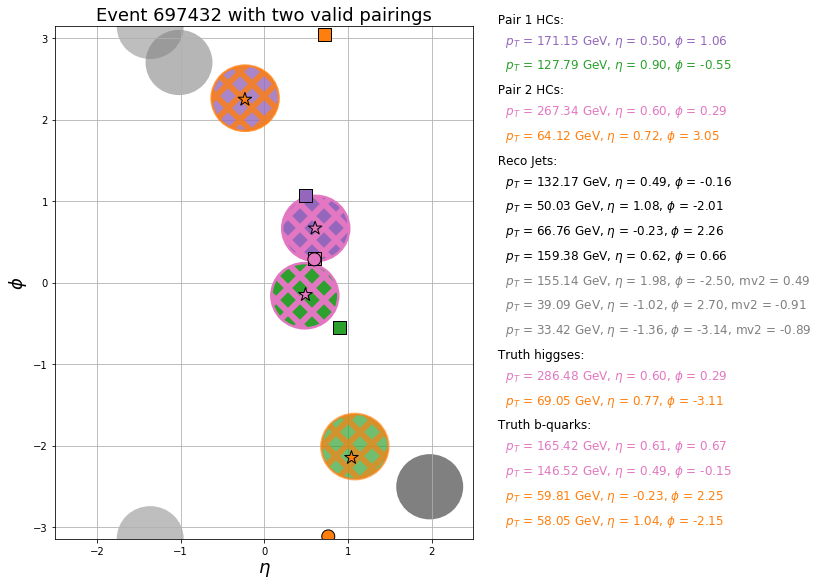

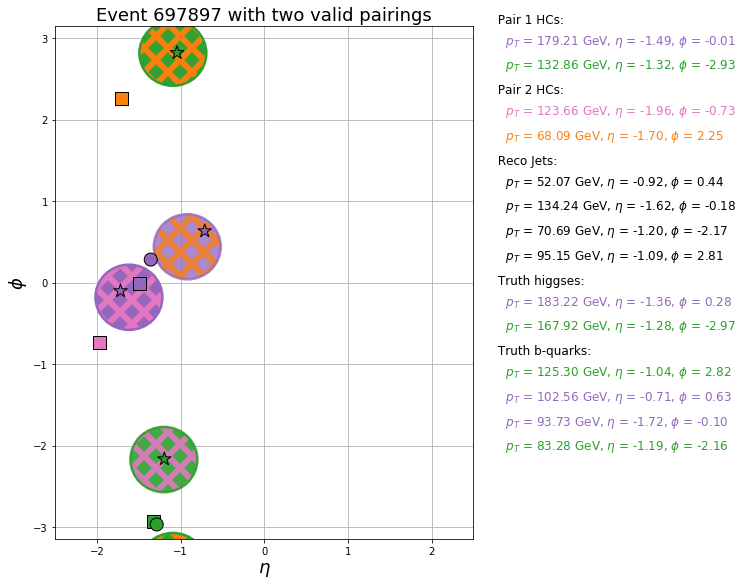

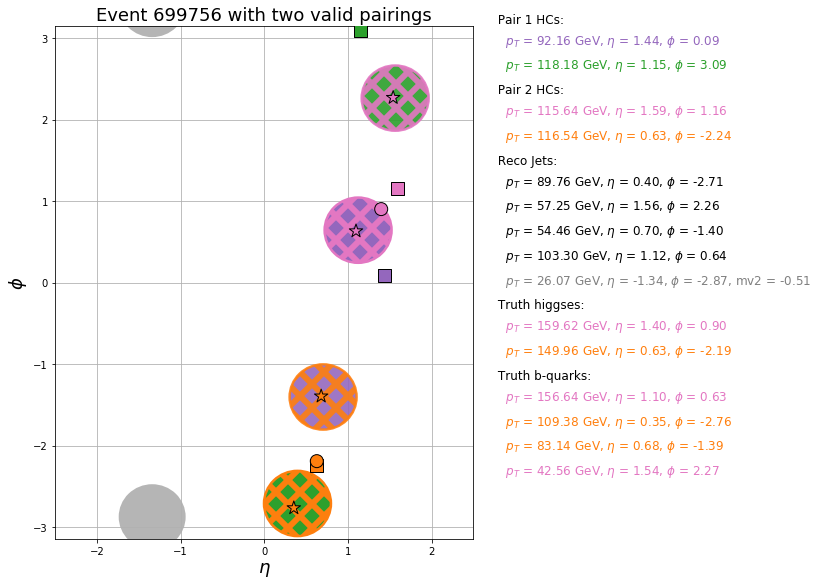

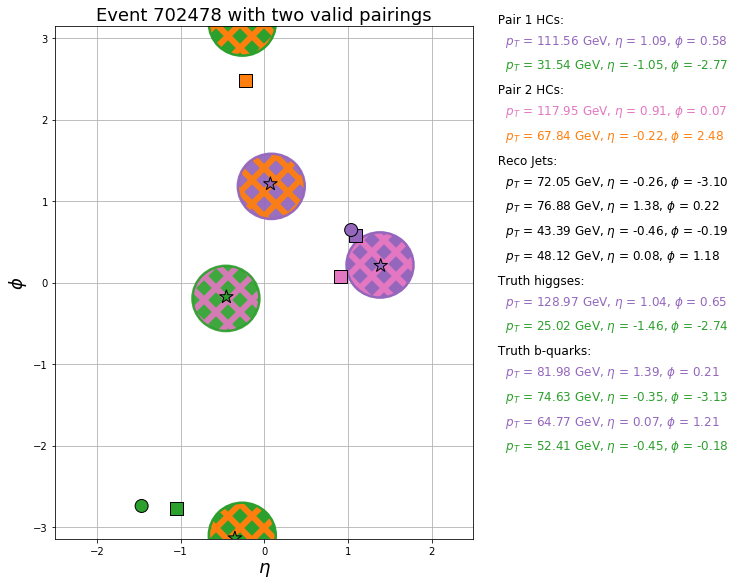

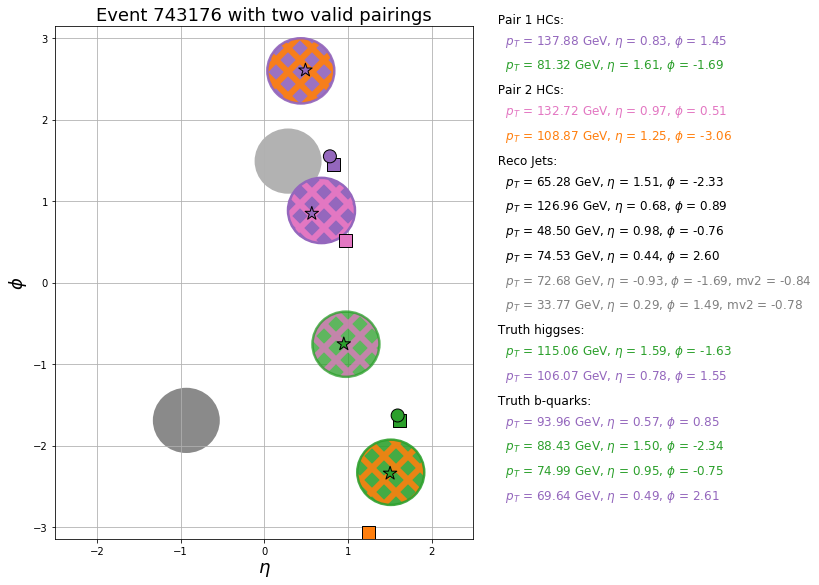

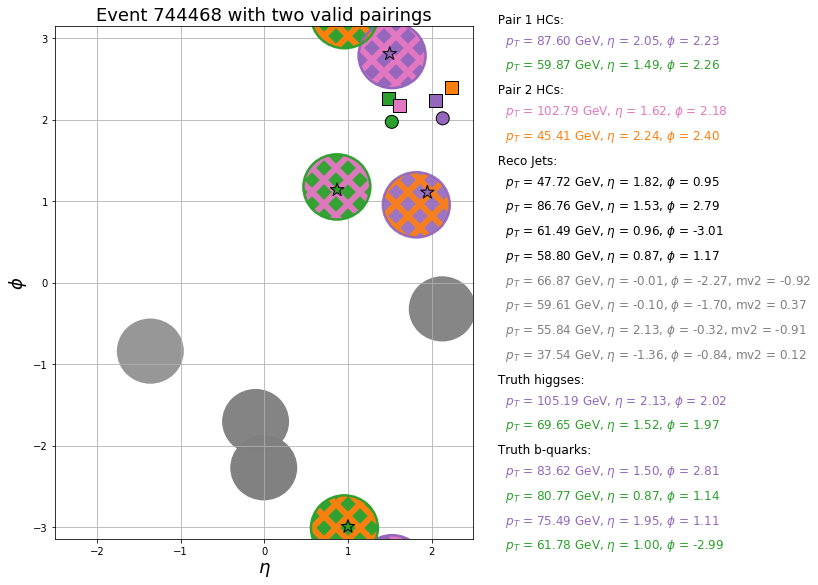

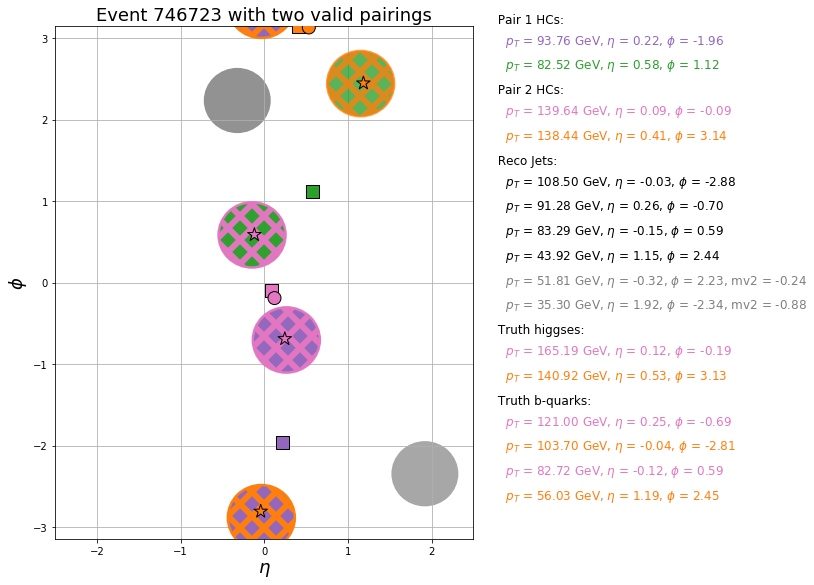

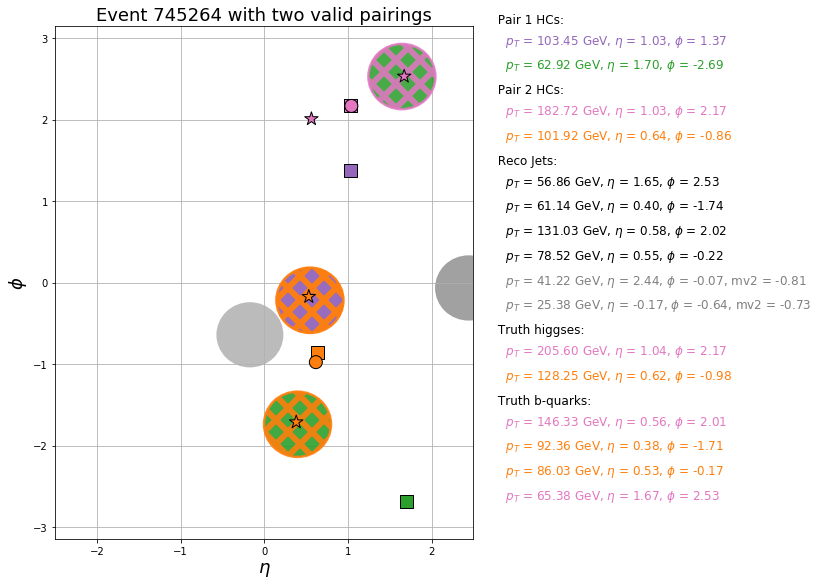

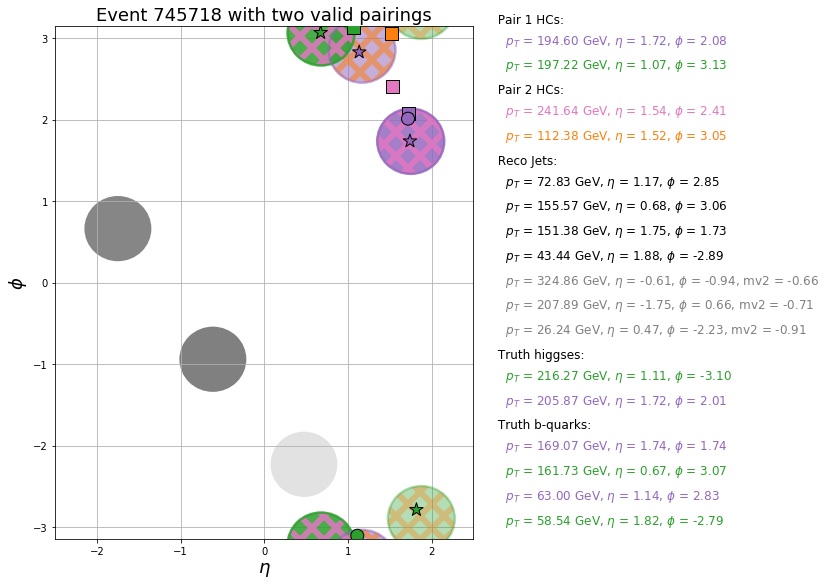

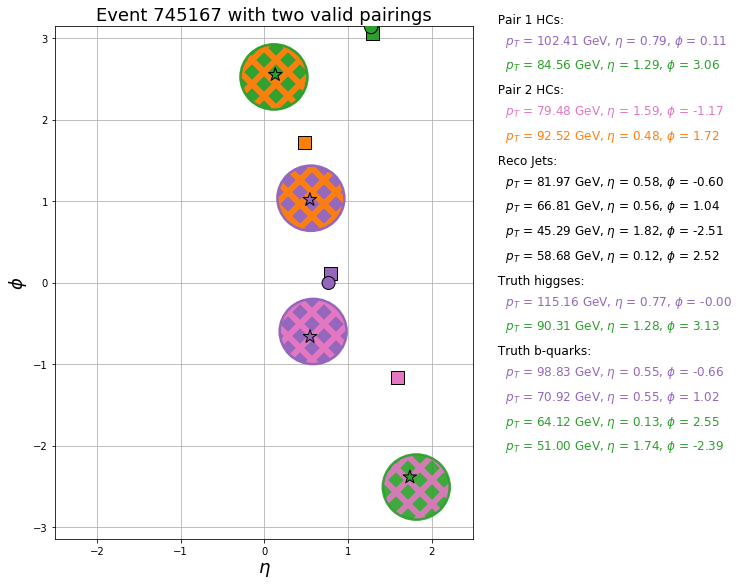

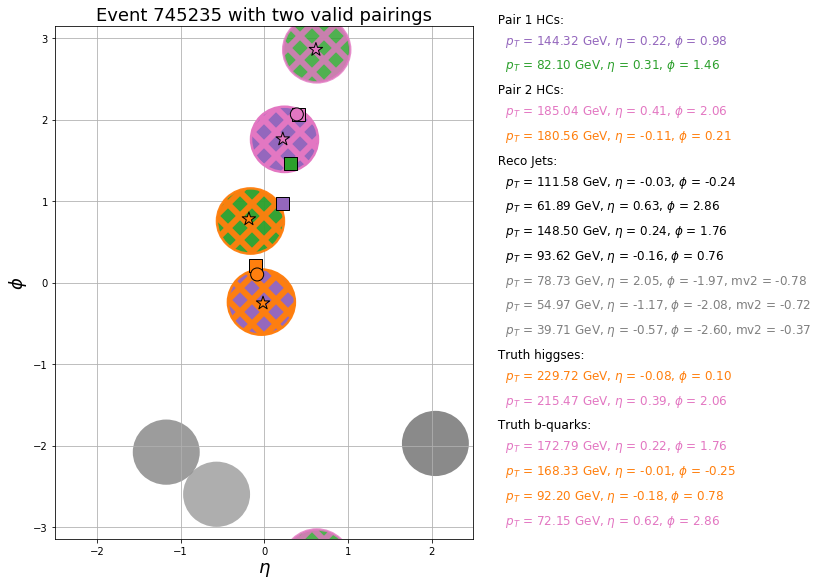

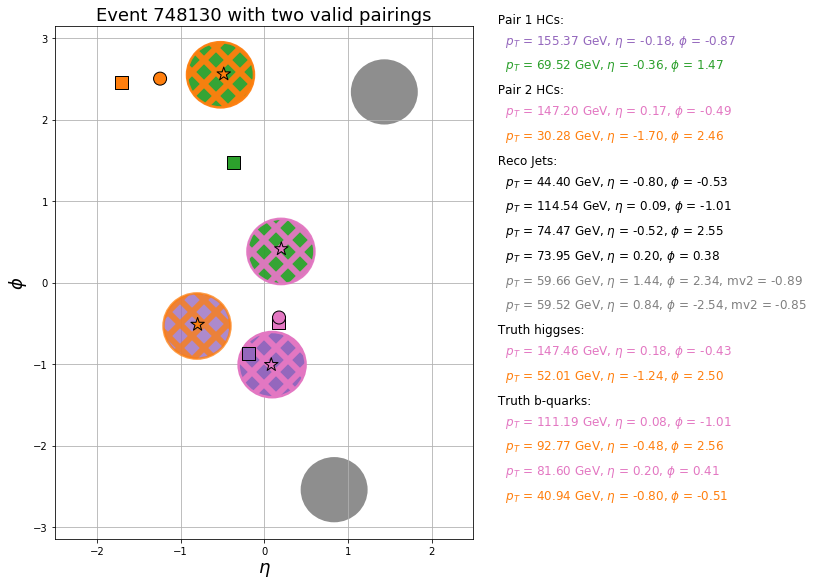

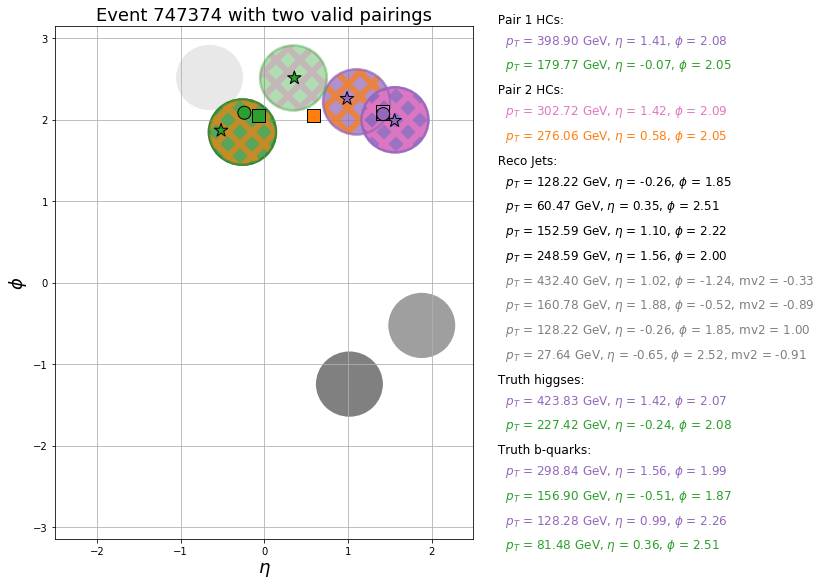

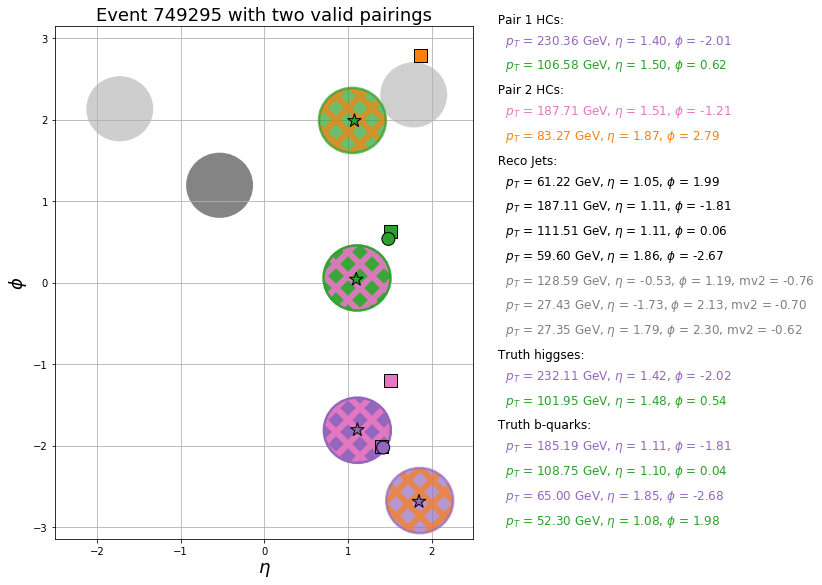

Error: Do not know how to assign edge color b/c the correctPair is not valid.


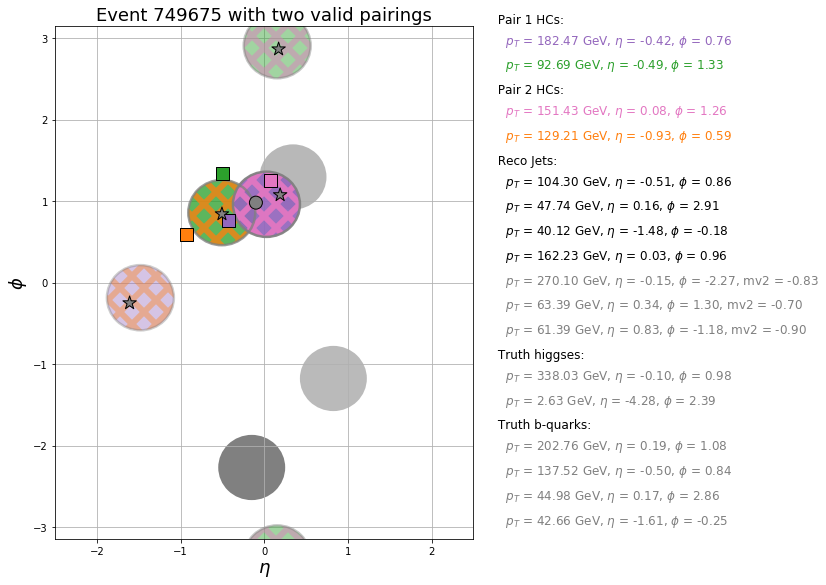

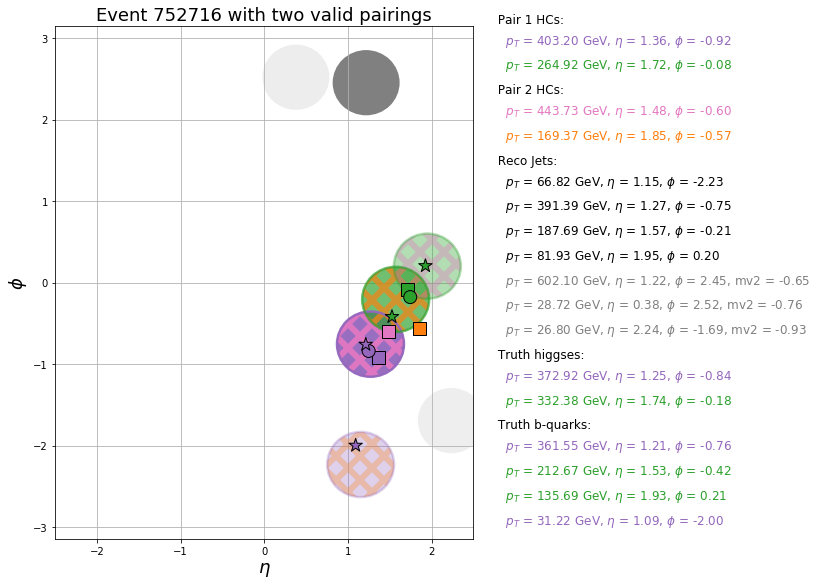

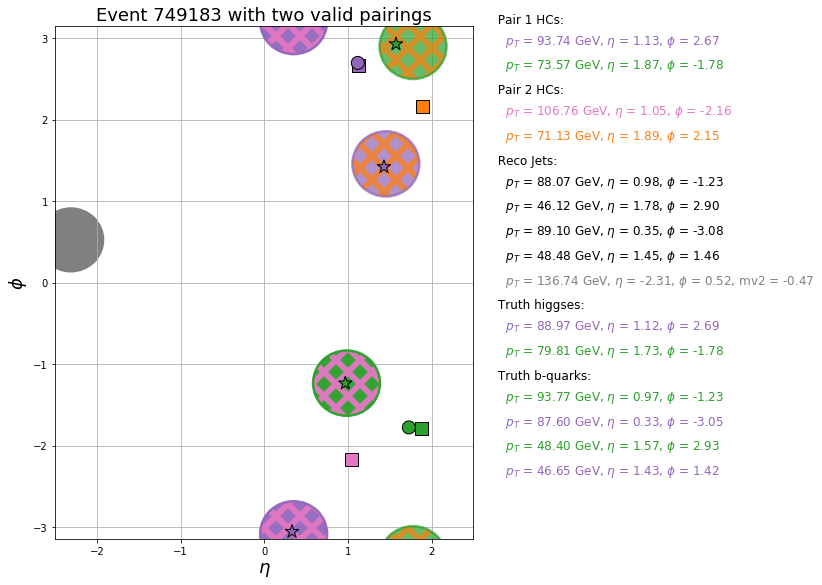

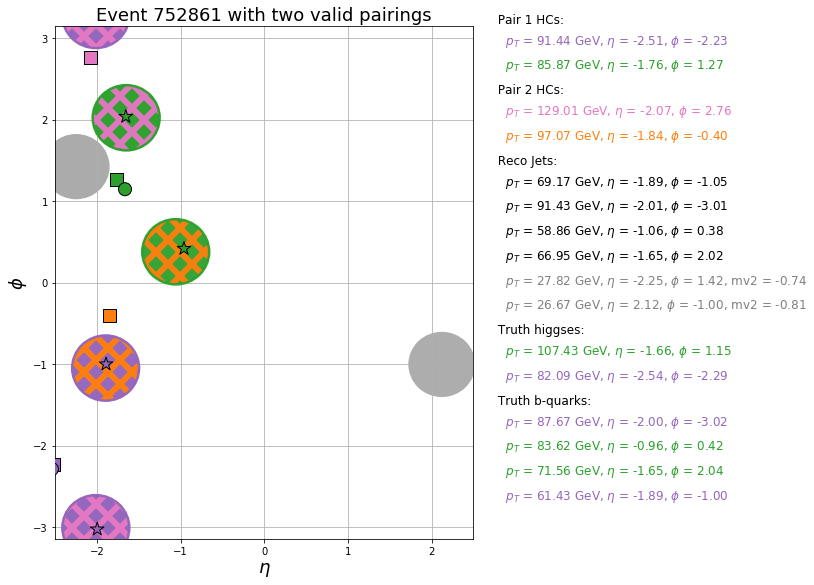

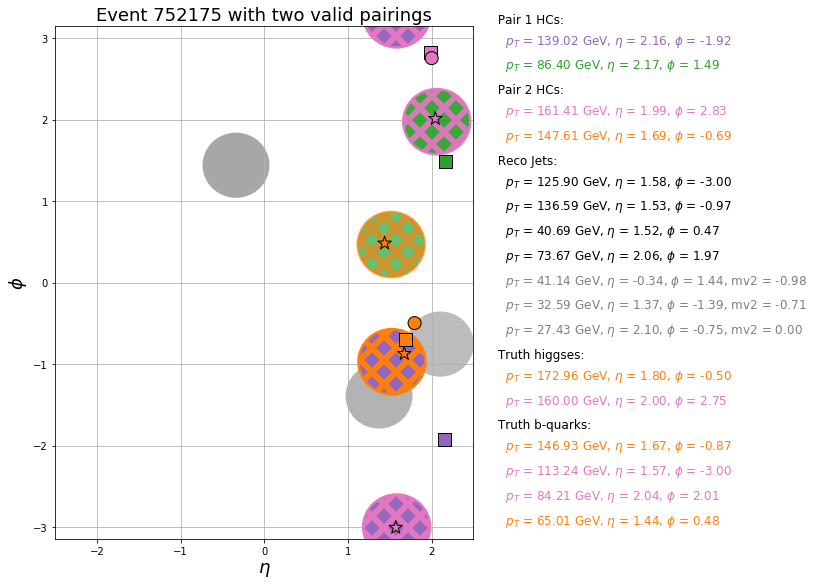

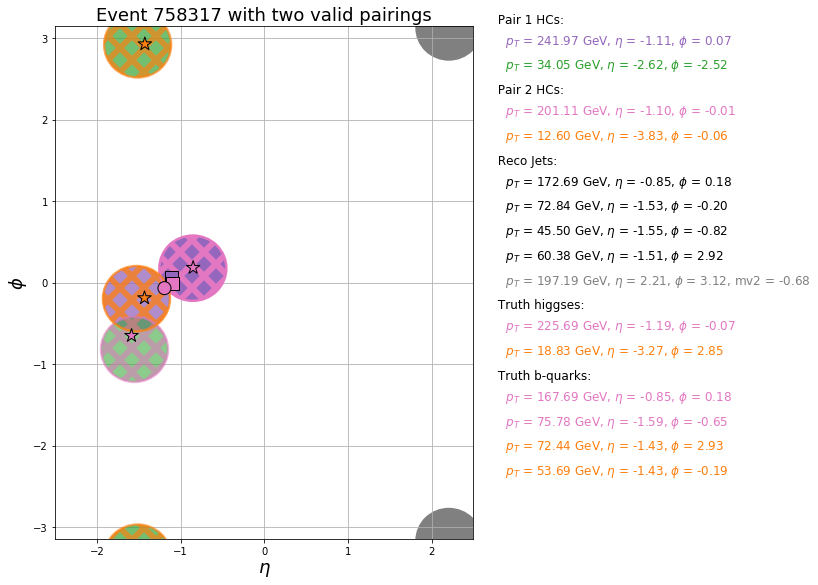

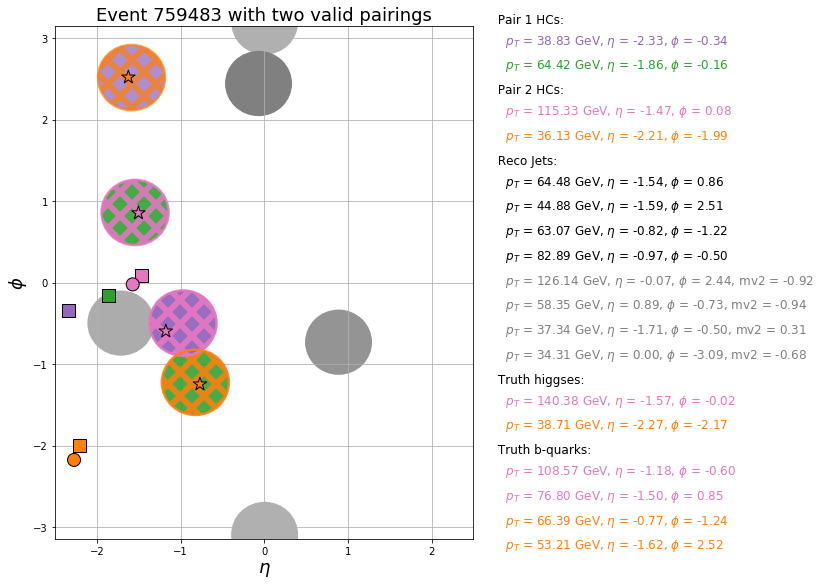

In [63]:
twoValidPairsDir = figDir+'twoValidPairings/'
if not os.path.exists(twoValidPairsDir):
    os.makedirs(twoValidPairsDir)

counter = 0

for ievt, nPairs in miniNtuple.loc[~badJets,'nValidPairs'].iteritems():
    if nPairs == 2:
        twoValidPairings(ievt,miniNtuple,figDir=twoValidPairsDir)
        counter += 1
        
    if counter == 25:
        break

Note: The analysis jets have the $\mu$-in-jet correction applied, the other jets do *not*.

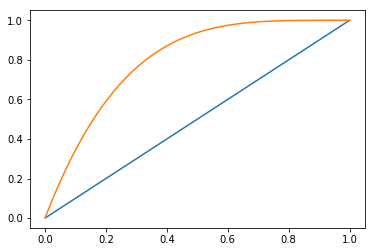

In [64]:
# I had to play about a bit with the normalization for alpha for the transparencies
# to look ok for all of the jets

x = np.linspace(0.001,1)
y = 1-(1-x)**4

plt.plot(x,x)
plt.plot(x,y)
plt.show()

**Follow-ups:** 
- Can we probe which ordering of the jets is most likely to lead to a correct HC?
- Can we use the recoiling jet $p_T$ to set a limit on the opening angles of the possible HCs? (This might already be accounted for by the current MDR cut)
- We already saw that the $p_T$s of the HCs are consisitent with the opening angles of their decay products?

What does it *mean* that most of the time we only see the purple and green as the true match?  Is there a way we can quantify this to see which of the pairings is mostly likely?